##### This script defines the encoders for the multimodal model
##### Overview:
- The inputs are the ESMC and Boltz embeddings 
- 3 encoders from PEFT of ESMC
- Two projection heads: one for ESM embeddings and one for Boltz embeddings
- Non contrastive learning

In [1]:
# Streamlined imports - removing duplicates
import time
import esm
import pandas as pd
import torch
from torch import Tensor
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR, LambdaLR
from torch.nn.utils.rnn import pad_sequence
from torch.amp import autocast
from torch.cuda.amp import GradScaler
import copy

import sys
import os
import time
import math
import random
import pickle
import subprocess
import gc
from pathlib import Path
from typing import List, Tuple

import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from IPython.display import display, update_display

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# ESM imports
from esm.models.esmc import ESMC
from esm.sdk.api import ESMProtein, LogitsConfig, ESMProteinTensor
from esm.models.esmc import _BatchedESMProteinTensor

# Tokenizer imports
from tokenizers import Tokenizer
from tokenizers.models import WordPiece
from tokenizers import normalizers
from tokenizers.normalizers import NFD, Lowercase, StripAccents
from tokenizers.pre_tokenizers import Whitespace
from tokenizers.trainers import WordPieceTrainer
from tokenizers import decoders

# PEFT imports
from peft import get_peft_model, LoraConfig, TaskType
from peft.tuners.lora import LoraConfig, LoraModel

# Set environment variable
os.environ["TOKENIZERS_PARALLELISM"] = "false"


/home/natasha/miniconda3/envs/tcr-multimodal/lib/python3.10/site-packages/torch/cuda/__init__.py:63: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


In [3]:
# Get current working directory and create models folder
import os
from pathlib import Path

# Get the current working directory
current_dir = os.getcwd()
print(f"Current working directory: {current_dir}")

# Get the project root (go up one level from scripts/train)
project_root = Path(current_dir).parent.parent
print(f"Project root: {project_root}")

# Create models directory in project root
models_dir = project_root / "models"
if not models_dir.exists():
    print(f"Models directory does not exist, creating it at: {models_dir}")
    models_dir.mkdir(exist_ok=True)
print(f"Models directory at: {models_dir}")

# Also create a checkpoints subdirectory for saving model checkpoints
checkpoints_dir = models_dir / "checkpoints"
if not checkpoints_dir.exists():
    print(f"Checkpoints directory does not exist, creating it at: {checkpoints_dir}")
    checkpoints_dir.mkdir(exist_ok=True)
print(f"Checkpoints directory at: {checkpoints_dir}")


Current working directory: /home/natasha/multimodal_model/scripts/train
Project root: /home/natasha/multimodal_model
Models directory at: /home/natasha/multimodal_model/models
Checkpoints directory at: /home/natasha/multimodal_model/models/checkpoints


##### Get ESM Embeddings

In [4]:
# need to load ESM C with LM head enabled 
# expose final token embeddings before the logits head (is logits head the LM head, LM head=language modelling head)?
# collator returns: input_ids, attention_mask

device = "cuda" if torch.cuda.is_available() else "cpu"
# load model and allow lora (rather than eval mode?)

In [5]:
# size = [1,7,960], always the case?
# size = [1, 12, 960]
# size is I think batch number, sequence length, embedding dimension

df = pd.read_csv('/home/natasha/multimodal_model/data/raw/HLA/boltz_100_runs.csv')
# Fill empty/nan values with <unk> token
df['TCRa'] = df['TCRa'].fillna('X')
df['TCRb'] = df['TCRb'].fillna('X')

# Replace empty strings with <unk>
df.loc[df['TCRa'] == '', 'TCRa'] = 'X'
df.loc[df['TCRb'] == '', 'TCRb'] = 'X'

df['TCR_full'] = df['TCRa'] + df['TCRb']
df['m_alpha'] = 1
df['m_beta'] = 1
df.loc[df['TCRa'] == 'X', 'm_alpha'] = 0
df.loc[df['TCRb'] == 'X', 'm_beta'] = 0
#df.to_csv('/home/natasha/multimodal_model/data/raw/HLA/boltz_100_runs.csv', index=False)

In [6]:
# read full train dataset



In [7]:
# hugging face dataset?
class TCR_dataset(Dataset):
    """Dataset for TCR data, for use in encoder training to propagate through to NC model"""
    def __init__(self, data_path, column_name='TCR_full', include_label=False):
        self.data_path = data_path
        self.data = pd.read_csv(data_path)
        self.column_name = column_name  # Store column name here
        self.include_label = include_label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):  # Remove column_name parameter
        row = self.data.iloc[idx]  # Fix: self.data, not self.csv
        protein = row[self.column_name]  # Use stored column name
        protein_idx = f'TCR_{idx}'
        if self.include_label:
            return protein_idx, protein, row.get('Binding', -1)
        #return protein_idx, protein
        return protein

class peptide_dataset(Dataset):
    def __init__(self, data_path, column_name='Peptide', include_label=False):
        self.data_path = data_path
        self.data = pd.read_csv(data_path)
        self.column_name = column_name
        self.include_label = include_label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        peptide = row[self.column_name]
        peptide_idx = f'peptide_{idx}'
        if self.include_label:
            return peptide_idx, peptide, row.get('Binding', -1)
        #return peptide_idx, peptide
        return peptide

class HLA_dataset(Dataset):
    def __init__(self, data_path, column_name='HLA', include_label=False):
        self.data_path = data_path
        self.data = pd.read_csv(data_path)
        self.column_name = column_name
        self.include_label = include_label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        hla = row[self.column_name]
        hla_idx = f'hla_{idx}'
        if self.include_label:
            return hla_idx, hla, row.get('Binding', -1)
        #return hla_idx, hla
        return hla

In [8]:
tcr = TCR_dataset(data_path='/home/natasha/multimodal_model/data/raw/HLA/boltz_100_runs.csv', column_name='TCR_full')
peptide = peptide_dataset(data_path='/home/natasha/multimodal_model/data/raw/HLA/boltz_100_runs.csv', column_name='Peptide')
hla = HLA_dataset(data_path='/home/natasha/multimodal_model/data/raw/HLA/boltz_100_runs.csv', column_name='HLA_sequence')

# not sure I reallt need these classes??? Hmmmmmm

In [9]:
tcrs = [ESMProtein(sequence=s) for s in tcr.data['TCR_full']]
peptides = [ESMProtein(sequence=s) for s in peptide.data['Peptide']]
hlas = [ESMProtein(sequence=s) for s in hla.data['HLA_sequence']]

# can batch at the forward step, not the encoding step

#model = ESMC.from_pretrained("esmc_300m").to(device).eval()
model = ESMC.from_pretrained("esmc_300m").eval()

tcrs_data = [seq for seq in tcr]
peptides_data = [seq for seq in peptide]
hlas_data = [seq for seq in hla]

encoded_tcrs = [model.encode(p) for p in tcrs]
encoded_peptides = [model.encode(p) for p in peptides]
encoded_hlas = [model.encode(p) for p in hlas]


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

##### Mask Data and Collate for MLM for Encoders

In [10]:
# do for entire dataset
# do we also want to output attention_mask from the tokenizer?

tok = model.tokenizer
CLS_ID = tok.cls_token_id
EOS_ID = tok.eos_token_id
PAD_ID = tok.pad_token_id
MASK_ID = tok.mask_token_id

AA_IDS =  [5,10,17,13,23,16,9,6,21,12,4,15,20,18,14,8,11,22,19,7]


class EncodedSeqDataset(Dataset):
    def __init__(self, sequences, enc):     # ← now takes two arguments
        self.sequences = sequences          # list[str]
        self.input_ids = enc['input_ids']
        self.attention_mask = enc['attention_mask']

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return {
            "sequence": self.sequences[idx],  # raw sequence string
            "input_ids": torch.as_tensor(self.input_ids[idx], dtype=torch.long),
            "attention_mask": torch.as_tensor(self.attention_mask[idx], dtype=torch.long),
        }


In [11]:
class MLMProteinCollator:
    def __init__(self, *, cls_id, eos_id, pad_id, mask_id, amino_acids,
                 p=0.15, min_per_seq=2, max_per_seq=45, aa_frac=0.20):
        self.CLS = cls_id
        self.EOS = eos_id
        self.PAD = pad_id
        self.MASK = mask_id
        self.aa = torch.as_tensor(amino_acids, dtype=torch.long)
        self.p = p
        self.min_per_seq = min_per_seq
        self.max_per_seq = max_per_seq
        self.aa_frac = aa_frac

    @torch.no_grad()
    def mask_batch(self, input_ids, attention_mask):
        device = input_ids.device
        aa = self.aa.to(device)

        B, L = input_ids.shape
        valid_mask = attention_mask.bool() \
                   & (input_ids != self.PAD) \
                   & (input_ids != self.CLS) \
                   & (input_ids != self.EOS)

        masked_input_ids = input_ids.clone()
        labels = torch.full_like(input_ids, -100)

        for i in range(B):
            vmask = valid_mask[i]
            if not vmask.any():
                continue

            valid_idx = vmask.nonzero(as_tuple=False).squeeze(1)  # (L_valid,)
            L_valid = valid_idx.numel()

            # how many to mask: floor(p*L_valid), clamped to [2, 45] but never > L_valid
            n = torch.floor(self.p * torch.tensor(L_valid, device=device, dtype=torch.float32)).to(torch.int64)
            n = torch.clamp(n, min=self.min_per_seq, max=min(self.max_per_seq, L_valid))
            if n.item() == 0:
                continue

            # choose n distinct valid positions
            chosen = valid_idx[torch.randperm(L_valid, device=device)[:n]]

            # split into AA vs MASK; ensure >=1 AA if n>=2
            n_amino = torch.floor(self.aa_frac * n).to(torch.int64)
            if n.item() >= 2:
                n_amino = torch.clamp(n_amino, min=1)
            n_mask = n - n_amino

            order = torch.randperm(n.item(), device=device)
            mask_pos  = chosen[order[:n_mask]]
            amino_pos = chosen[order[n_mask:]]

            # labels only at supervised positions
            labels[i, chosen] = input_ids[i, chosen]

            # apply edits
            if n_mask.item() > 0:
                masked_input_ids[i, mask_pos] = self.MASK
            if n_amino.item() > 0:
                r_idx = torch.randint(high=aa.numel(), size=(n_amino.item(),), device=device)
                masked_input_ids[i, amino_pos] = aa[r_idx]

        return masked_input_ids, labels


    def __call__(self, features):
        input_ids = torch.stack([f["input_ids"] for f in features], dim=0)
        attention_mask = torch.stack([f["attention_mask"] for f in features], dim=0)
        sequences = [f["sequence"] for f in features]
        proteins = [ESMProtein(sequence=f["sequence"]) for f in features]
        batched_clean = _BatchedESMProteinTensor(sequence=input_ids)


        masked_input_ids, labels = self.mask_batch(input_ids, attention_mask)

        # build masked sequences as strings (keep <mask>, drop CLS/EOS/PAD)
        masked_sequences = []
        for row in masked_input_ids.tolist():
            toks = collator.tokenizer.convert_ids_to_tokens(row, skip_special_tokens=False)
            aa = []
            for t in toks:
                if t in (collator.tokenizer.cls_token, collator.tokenizer.eos_token, collator.tokenizer.pad_token):
                    continue
                aa.append(t)  # AA tokens are single letters; keep "<mask>" as is
            masked_sequences.append("".join(aa))

        proteins_masked = [ESMProtein(sequence=s) for s in masked_sequences]
        batched_masked = _BatchedESMProteinTensor(sequence=masked_input_ids)


        return {
            "masked_input_ids": masked_input_ids,
            "labels": labels,
            "attention_mask": attention_mask,
            "clean_input_ids": input_ids.clone(),
            "clean_sequences": sequences,                 # clean strings
            "masked_sequences": masked_sequences,   # masked strings  ← NEW
            "clean_sequences_ESMprotein": proteins,
            "masked_sequences_ESMprotein": proteins_masked,
            "masked_input_ids_ESMprotein_batched": batched_masked,
            "clean_input_ids_ESMprotein_batched": batched_clean,
        }

In [12]:
# Your existing BatchEncodings:
# clean_tcrs_tokenized, clean_peptides_tokenized, clean_hlas_tokenized
clean_tcrs_tokenized = model.tokenizer(tcrs_data, return_tensors='pt', padding=True)
clean_peptides_tokenized = model.tokenizer(peptides_data, return_tensors='pt', padding=True)
clean_hlas_tokenized = model.tokenizer(hlas_data, return_tensors='pt', padding=True)

tcr_ds = EncodedSeqDataset(tcrs_data,clean_tcrs_tokenized)
pep_ds = EncodedSeqDataset(peptides_data, clean_peptides_tokenized)
hla_ds = EncodedSeqDataset(hlas_data, clean_hlas_tokenized)

collator = MLMProteinCollator(
    cls_id=CLS_ID, eos_id=EOS_ID, pad_id=PAD_ID, mask_id=MASK_ID,
    amino_acids=AA_IDS, p=0.15, min_per_seq=2, max_per_seq=45, aa_frac=0.20
)
collator.tokenizer = model.tokenizer


tcr_loader = DataLoader(tcr_ds, batch_size=8, shuffle=True, num_workers=4, collate_fn=collator)
pep_loader = DataLoader(pep_ds, batch_size=8, shuffle=True, num_workers=4, collate_fn=collator)
hla_loader = DataLoader(hla_ds, batch_size=8, shuffle=True, num_workers=4, collate_fn=collator)


# gives a batch dict from the collator with 4 keys
# input_ids, labels (original tokens only at masked positions, -100 everywhere else)
# attention_mask (0,1 for padding), clean_input_ids (clean copy of the input for clean forward pass using boltz for NC loss)

# model.to("cpu")
# torch.cuda.empty_cache()

def optimizer_to_cpu(optim):
    for st in optim.state.values():
        for k, v in list(st.items()):
            if torch.is_tensor(v):
                st[k] = v.detach().to("cpu")

# move model to CPU and delete, as now we have the correct inputs 
model.to("cpu")
del model
torch.cuda.empty_cache()

In [13]:

use_amp = torch.cuda.is_available()

#base = ESMC.from_pretrained("esmc_300m").to(device)
#base = ESMC.from_pretrained("esmc_300m")

lora_cfg = LoraConfig(
    r=8, lora_alpha=32, lora_dropout=0.05, bias="none",
    target_modules=["out_proj", "layernorm_qkv.1"],  # inner Linear inside the Sequential
)

model_tcr = LoraModel(ESMC.from_pretrained("esmc_300m"), lora_cfg, adapter_name="tcr")


#model_tcr = LoraModel(base, lora_cfg, adapter_name="tcr")

# freeze everything; unfreeze only LoRA params
for p in model_tcr.parameters():
    p.requires_grad = False
for name, p in model_tcr.named_parameters():
    if "lora_A" in name or "lora_B" in name:
        p.requires_grad = True

model_tcr.to("cuda")
model_tcr.train()

optim_tcr = torch.optim.AdamW(
    (p for p in model_tcr.parameters() if p.requires_grad),
    lr=1e-3, weight_decay=0.01
)


use_amp = torch.cuda.is_available()
scaler  = GradScaler(enabled=False)                     # <-- no scaler

for batch in tcr_loader:
    input_ids = batch["masked_input_ids"].to(device, dtype=torch.long)
    labels    = batch["labels"].to(device)

    with autocast("cuda", enabled=use_amp, dtype=torch.bfloat16):  # <-- bf16
        out    = model_tcr(input_ids)
        logits = out.sequence_logits
        #print(type(logits), logits.shape, logits.requires_grad)  # expect: Tensor, [B,L,V], True

        loss   = F.cross_entropy(
            logits.view(-1, logits.size(-1)),
            labels.view(-1),
            ignore_index=-100
        )

    loss.backward()                                     # <-- standard backward
    optim_tcr.step(); optim_tcr.zero_grad(set_to_none=True)

    del out, logits, loss, input_ids, labels, batch
    torch.cuda.synchronize()


# 1.1 seconds for 100
# 11 for 1000
# 110 for 10000
# 350 for 35000 - 5.8 minutes to train one encoder on full dataset

optimizer_to_cpu(optim_tcr)

# save tcr model

checkpoint_filename = 'tcr_encoder_checkpoint.pth'

checkpoint_dict = {
    #'epoch': num_epochs,
    'tcr_model_state_dict': model_tcr.state_dict(),
    #'pep_model_state_dict': peptide_model_nc.state_dict(), 
    'optimizer_state_dict': optim_tcr.state_dict(),
    #'final_loss': avg_epoch_loss,
    #'binding_threshold': threshold  # Add threshold to saved state
}

torch.save(checkpoint_dict, checkpoints_dir/checkpoint_filename)

print(f"Checkpoint saved to {checkpoint_filename}")

model_tcr.to("cpu")

del optim_tcr, model_tcr, checkpoint_dict, checkpoint_filename

torch.cuda.empty_cache()  # Free up GPU memory



/tmp/ipykernel_784697/627727058.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler  = GradScaler(enabled=False)                     # <-- no scaler


Checkpoint saved to tcr_encoder_checkpoint.pth


In [14]:
# peptide encoder

use_amp = torch.cuda.is_available()

#base = ESMC.from_pretrained("esmc_300m").to(device)

## use the same lora config for peptide and HLA - modify later
# lora_cfg = LoraConfig(
#     r=8, lora_alpha=32, lora_dropout=0.05, bias="none",
#     target_modules=["out_proj", "layernorm_qkv.1"],  # inner Linear inside the Sequential
# )

model_pep = LoraModel(ESMC.from_pretrained("esmc_300m"), lora_cfg, adapter_name="pep")
#model_pep = LoraModel(base, lora_cfg, adapter_name="peptide")

# freeze everything; unfreeze only LoRA params
for p in model_pep.parameters():
    p.requires_grad = False
for name, p in model_pep.named_parameters():
    if "lora_A" in name or "lora_B" in name:
        p.requires_grad = True

model_pep.to("cuda")
model_pep.train()

optim_pep = torch.optim.AdamW(
    (p for p in model_pep.parameters() if p.requires_grad),
    lr=1e-3, weight_decay=0.01
)

use_amp = torch.cuda.is_available()
scaler  = GradScaler(enabled=False)                     # <-- no scaler

for batch in pep_loader:
    input_ids = batch["masked_input_ids"].to(device, dtype=torch.long)
    labels    = batch["labels"].to(device)

    with autocast("cuda", enabled=use_amp, dtype=torch.bfloat16):  # <-- bf16
        out    = model_pep(input_ids)
        logits = out.sequence_logits
        #print(type(logits), logits.shape, logits.requires_grad)  # expect: Tensor, [B,L,V], True

        loss   = F.cross_entropy(
            logits.view(-1, logits.size(-1)),
            labels.view(-1),
            ignore_index=-100
        )

    loss.backward()                                     # <-- standard backward
    optim_pep.step(); optim_pep.zero_grad(set_to_none=True)

    del out, logits, loss, input_ids, labels, batch
    torch.cuda.synchronize()

optimizer_to_cpu(optim_pep)

# save peptide model

checkpoint_filename = 'peptide_encoder_checkpoint.pth'

checkpoint_dict = {
    #'epoch': num_epochs,
    'peptide_model_state_dict': model_pep.state_dict(),
    'optimizer_state_dict': optim_pep.state_dict(),
    #'final_loss': avg_epoch_loss,
    #'binding_threshold': threshold  # Add threshold to saved state
}

torch.save(checkpoint_dict, checkpoints_dir/checkpoint_filename)

print(f"Checkpoint saved to {checkpoint_filename}")

model_pep.to("cpu")
del optim_pep, model_pep, checkpoint_dict, checkpoint_filename
torch.cuda.empty_cache() 

#print(torch.cuda.memory_summary())           # “Active” bytes should drop


/tmp/ipykernel_784697/363416641.py:32: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler  = GradScaler(enabled=False)                     # <-- no scaler


Checkpoint saved to peptide_encoder_checkpoint.pth


In [15]:
# HLA encoder

use_amp = torch.cuda.is_available()

#base = ESMC.from_pretrained("esmc_300m").to(device)

## use the same lora config for peptide and HLA - modify later
# lora_cfg = LoraConfig(
#     r=8, lora_alpha=32, lora_dropout=0.05, bias="none",
#     target_modules=["out_proj", "layernorm_qkv.1"],  # inner Linear inside the Sequential
# )

#model_hla = LoraModel(base, lora_cfg, adapter_name="hla")
model_hla = LoraModel(ESMC.from_pretrained("esmc_300m"), lora_cfg, adapter_name="hla")


# freeze everything; unfreeze only LoRA params
for p in model_hla.parameters():
    p.requires_grad = False
for name, p in model_hla.named_parameters():
    if "lora_A" in name or "lora_B" in name:
        p.requires_grad = True

model_hla.to("cuda")
model_hla.train()

optim_hla = torch.optim.AdamW(
    (p for p in model_hla.parameters() if p.requires_grad),
    lr=1e-3, weight_decay=0.01
)

use_amp = torch.cuda.is_available()
scaler  = GradScaler(enabled=False)                     # <-- no scaler

for batch in hla_loader:
    input_ids = batch["masked_input_ids"].to(device, dtype=torch.long)
    labels    = batch["labels"].to(device)

    with autocast("cuda", enabled=use_amp, dtype=torch.bfloat16):  # <-- bf16
        out    = model_hla(input_ids)
        logits = out.sequence_logits
        #print(type(logits), logits.shape, logits.requires_grad)  # expect: Tensor, [B,L,V], True

        loss   = F.cross_entropy(
            logits.view(-1, logits.size(-1)),
            labels.view(-1),
            ignore_index=-100
        )

    loss.backward()                                     # <-- standard backward
    optim_hla.step()
    optim_hla.zero_grad(set_to_none=True)

    # clear memory
    del out, logits, loss, input_ids, labels, batch
    torch.cuda.synchronize()


optimizer_to_cpu(optim_hla)

# save HLA model

checkpoint_filename = 'hla_encoder_checkpoint.pth'

checkpoint_dict = {
    #'epoch': num_epochs,
    'hla_model_state_dict': model_hla.state_dict(),
    'optimizer_state_dict': optim_hla.state_dict(),
    #'final_loss': avg_epoch_loss,
    #'binding_threshold': threshold  # Add threshold to saved state
}

torch.save(checkpoint_dict, checkpoints_dir/checkpoint_filename)

print(f"Checkpoint saved to {checkpoint_filename}")

model_hla.to("cpu")
del optim_hla, model_hla, checkpoint_dict, checkpoint_filename
torch.cuda.empty_cache() 

/tmp/ipykernel_784697/2523016605.py:33: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler  = GradScaler(enabled=False)                     # <-- no scaler


Checkpoint saved to hla_encoder_checkpoint.pth


#### Load Encoders and Boltz Embeddings

a) Load encoders and create boltz loader function

In [16]:
#device = 'cpu'

In [17]:
"""
LOADING ENCODERS FOR USE AS FIXED FEATURE EXTRACTORS

Use case: You're NOT continuing to train the encoders. Instead, you'll use them
as fixed/pre-trained components in the next part of your training pipeline (likely
the multimodal model that combines TCR, peptide, and HLA embeddings).

WHAT YOU NEED:
✅ Model weights (to get the fine-tuned LoRA adapters)
✅ Set to .eval() mode (to disable dropout, use batch norm stats, etc.)

WHAT YOU DON'T NEED:
❌ Optimizer state - only needed if you were continuing to train the encoders

NOTE: The checkpoint contains 'optimizer_state_dict', but we're ignoring it
since we're using these models as frozen feature extractors.
"""

# Step 1: Load the checkpoint dictionaries (just Python dicts from disk)
# checkpoint_tcr = torch.load(checkpoints_dir/'tcr_encoder_checkpoint.pth', map_location=device)
# checkpoint_pep = torch.load(checkpoints_dir/'peptide_encoder_checkpoint.pth', map_location=device)
# checkpoint_hla = torch.load(checkpoints_dir/'hla_encoder_checkpoint.pth', map_location=device)
checkpoint_tcr = torch.load(checkpoints_dir/'tcr_encoder_checkpoint.pth', map_location='cpu')
checkpoint_pep = torch.load(checkpoints_dir/'peptide_encoder_checkpoint.pth', map_location='cpu')
checkpoint_hla = torch.load(checkpoints_dir/'hla_encoder_checkpoint.pth', map_location='cpu')

# Step 2: Recreate the model architectures (same as during training)
lora_cfg = LoraConfig(
    r=8, lora_alpha=32, lora_dropout=0.05, bias="none",
    target_modules=["out_proj", "layernorm_qkv.1"],
)

# Create models with same architecture as during training
tcr_encoder = LoraModel(ESMC.from_pretrained("esmc_300m"), lora_cfg, adapter_name="tcr")
peptide_encoder = LoraModel(ESMC.from_pretrained("esmc_300m"), lora_cfg, adapter_name="pep")
hla_encoder = LoraModel(ESMC.from_pretrained("esmc_300m"), lora_cfg, adapter_name="hla")

# Step 3: Load the model state dictionaries (this loads base weights + LoRA adapters)
# NOTE: We're NOT loading optimizer_state_dict - not needed for inference/feature extraction
tcr_encoder.load_state_dict(checkpoint_tcr['tcr_model_state_dict'])
peptide_encoder.load_state_dict(checkpoint_pep['peptide_model_state_dict'])
hla_encoder.load_state_dict(checkpoint_hla['hla_model_state_dict'])

# Step 4: Set to evaluation mode and move to CPU
# .eval() mode ensures: no dropout, batch norm uses running stats, etc.
# tcr_encoder.to('cpu').eval()
# peptide_encoder.to('cpu').eval()
# hla_encoder.to('cpu').eval()

# Load to GPU becuase we need to get the embeddings in the forward pass
tcr_encoder.to(device).eval()
peptide_encoder.to(device).eval()
hla_encoder.to(device).eval()

print("✓ Encoders loaded successfully as fixed feature extractors!")
print("  (Optimizer state skipped - not needed for this use case)")



✓ Encoders loaded successfully as fixed feature extractors!
  (Optimizer state skipped - not needed for this use case)


In [18]:
print(os.getcwd())

home = '/home/natasha/multimodal_model'
#manifest_path = os.path.join(home, 'data', 'manifests', 'boltz_100_manifest.csv')
positive_manifest_path = os.path.join(home, 'data', 'manifests', 'boltz_100_manifest.csv')
negative_manifest_path = os.path.join(home, 'data', 'negative_manifests', 'boltz_100_manifest.csv')
#print(manifest_path)

#manifest_data = pd.read_csv(manifest_path)
positive_manifest_data = pd.read_csv(positive_manifest_path)
negative_manifest_data = pd.read_csv(negative_manifest_path)
manifest_data = pd.concat([positive_manifest_data, negative_manifest_data])

L_T_max_boltz = max(manifest_data['tcra_len']+manifest_data['tcrb_len'])
L_PH_max_boltz = max(manifest_data['pep_len']+manifest_data['hla_len'])

print(L_T_max_boltz, L_PH_max_boltz)


/home/natasha/multimodal_model/scripts/train
456 377


In [19]:
# # get Boltz dataset
# # old version

# class BoltzDataset(Dataset):
#     """
#     Dataset for loading Boltz z-embeddings one by one,
#     with chain lengths from the manifest.
#     Each pair has its own .npz file.
#     ORIGINAL VERSION - returns numpy arrays
#     """
#     def __init__(self, manifest_path, base_path):
#         self.manifest = pd.read_csv(manifest_path)
#         self.base_path = base_path

#     def __len__(self):
#         return len(self.manifest)

#     def __getitem__(self, idx):
#         yaml_rel_path = self.manifest.iloc[idx]['yaml_path']
#         pair_id = os.path.splitext(os.path.basename(yaml_rel_path))[0]
#         emb_path = os.path.join(
#             self.base_path,
#             'outputs',
#             'boltz_runs',
#             'positives',
#             pair_id,
#             f'boltz_results_{pair_id}',
#             'predictions',
#             pair_id,
#             f'embeddings_{pair_id}.npz'
#         )
#         with np.load(emb_path) as arr:
#             z = arr['z']  # Returns numpy array as-is
#         pep_len = self.manifest.iloc[idx]['pep_len']
#         tcra_len = self.manifest.iloc[idx]['tcra_len']
#         tcrb_len = self.manifest.iloc[idx]['tcrb_len']
#         hla_len = self.manifest.iloc[idx]['hla_len']
#         return z, pep_len, tcra_len, tcrb_len, hla_len



# def boltz_collate_fn(batch):
#     """
#     Pad Boltz z to max L in batch; return torch tensors
#     """
#     zs, pep_lens, tcra_lens, tcrb_lens, hla_lens = zip(*batch)

#     # Each z: [L, L, dim] or [1, L, L, dim]
#     zs = [np.squeeze(z, axis=0) for z in zs]  # ensure (L, L, dB)

#     max_len = max(z.shape[0] for z in zs)
#     dim = zs[0].shape[-1]

#     padded_zs = np.zeros((len(zs), max_len, max_len, dim), dtype=zs[0].dtype)
#     for i, z in enumerate(zs):
#         L = z.shape[0]
#         padded_zs[i, :L, :L, :] = z

#     zs_torch = torch.from_numpy(padded_zs).float()

#     pep_lens_t  = torch.as_tensor(pep_lens,  dtype=torch.long)
#     tcra_lens_t = torch.as_tensor(tcra_lens, dtype=torch.long)
#     tcrb_lens_t = torch.as_tensor(tcrb_lens, dtype=torch.long)
#     hla_lens_t  = torch.as_tensor(hla_lens,  dtype=torch.long)

#     return {
#         "z": zs_torch,          # (B, L_pad, L_pad, dB)
#         "pep_len":  pep_lens_t, # (B,)
#         "tcra_len": tcra_lens_t,
#         "tcrb_len": tcrb_lens_t,
#         "hla_len":  hla_lens_t,
#     }


# # # Usage:
# # dataset_original = BoltzDataset(manifest_path, home)
# # dataloader_original = DataLoader(
# #     dataset_original, batch_size=8, shuffle=True, collate_fn=boltz_collate_fn
# # )


# # batch = next(iter(dataloader_original))
# # print("Batch z shapes:", [z.shape for z in batch["z"]])
# # print("Pep lengths:", batch["pep_len"])

# # 5.6s to load 100 pairs
# # 56 s to load 1000 pairs
# # 560 s to load 10000 pairs (9 mins)
# # 5600 s to load 100000 pairs (16 mins)

In [20]:
class BoltzDataset(Dataset):
    def __init__(self, manifest_path, base_path, split_dir, strict=False):
        """
        split_dir: e.g. 'positives' or 'negatives'
        strict=False: if True, raise when a file is missing; else filter it out.
        """
        self.base_path = base_path
        self.split_dir = split_dir
        manifest = pd.read_csv(manifest_path)

        valid_rows = []
        missing = 0

        for i in range(len(manifest)):
            yaml_rel_path = manifest.iloc[i]['yaml_path']
            pair_id = os.path.splitext(os.path.basename(yaml_rel_path))[0]
            emb_path = os.path.join(
                self.base_path,
                'outputs', 'boltz_runs',
                self.split_dir,
                pair_id,
                f'boltz_results_{pair_id}',
                'predictions',
                pair_id,
                f'embeddings_{pair_id}.npz'
            )
            if os.path.exists(emb_path):
                row = manifest.iloc[i].copy()
                row["pair_id"] = pair_id
                row["emb_path"] = emb_path
                valid_rows.append(row)
            else:
                missing += 1
                if strict:
                    raise FileNotFoundError(f"Missing: {emb_path}")

        self.manifest = pd.DataFrame(valid_rows).reset_index(drop=True)
        print(f"[BoltzDataset:{split_dir}] kept {len(self.manifest)} rows, filtered {missing} missing files.")

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        row = self.manifest.iloc[idx]
        emb_path = row["emb_path"]

        with np.load(emb_path) as arr:
            z = arr["z"]

        z = np.squeeze(z, axis=0) if z.ndim == 4 else z  # (L,L,dB)
        L_pad = z.shape[0]

        pep_len  = int(row["pep_len"])
        tcra_len = int(row["tcra_len"])
        tcrb_len = int(row["tcrb_len"])
        hla_len  = int(row["hla_len"])

        # --- clamp lengths so (tcra+tcrb+pep+hla) never exceeds what z contains ---
        L_T  = tcra_len + tcrb_len
        L_PH = pep_len + hla_len
        L_total = L_T + L_PH

        if L_total > L_pad:
            L_T_new = min(L_T, L_pad)
            remaining = L_pad - L_T_new
            L_PH_new = min(L_PH, remaining)

            tcra_new = min(tcra_len, L_T_new)
            tcrb_new = min(tcrb_len, L_T_new - tcra_new)

            pep_new = min(pep_len, L_PH_new)
            hla_new = min(hla_len, L_PH_new - pep_new)

            tcra_len, tcrb_len, pep_len, hla_len = tcra_new, tcrb_new, pep_new, hla_new

        return z, pep_len, tcra_len, tcrb_len, hla_len


def boltz_collate_fn(batch):
    """
    Pad Boltz z to max L in batch; return torch tensors.
    Handles z stored as either (L,L,dB) or (1,L,L,dB).
    """
    zs, pep_lens, tcra_lens, tcrb_lens, hla_lens = zip(*batch)

    zs_fixed = []
    for z in zs:
        # z can be (L,L,dB) or (1,L,L,dB)
        if z.ndim == 4:
            # only squeeze if leading dim is actually 1
            if z.shape[0] == 1:
                z = z[0]  # -> (L,L,dB)
            else:
                # unexpected but handle: take first element
                z = z[0]
        elif z.ndim != 3:
            raise ValueError(f"Unexpected z ndim={z.ndim}, shape={z.shape}")

        zs_fixed.append(z)

    max_len = max(z.shape[0] for z in zs_fixed)
    dim = zs_fixed[0].shape[-1]

    padded_zs = np.zeros((len(zs_fixed), max_len, max_len, dim), dtype=zs_fixed[0].dtype)
    for i, z in enumerate(zs_fixed):
        L = z.shape[0]
        padded_zs[i, :L, :L, :] = z

    zs_torch = torch.from_numpy(padded_zs).float()

    return {
        "z": zs_torch,  # (B, L_pad, L_pad, dB)
        "pep_len":  torch.as_tensor(pep_lens,  dtype=torch.long),
        "tcra_len": torch.as_tensor(tcra_lens, dtype=torch.long),
        "tcrb_len": torch.as_tensor(tcrb_lens, dtype=torch.long),
        "hla_len":  torch.as_tensor(hla_lens,  dtype=torch.long),
    }




b) Load Embeddings: Pre-compute embeddings so we don't have to do it at the forward step

In [21]:
#device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [22]:
# ESM embeddings 

all_emb_T, all_emb_P, all_emb_H = [], [], []
all_mask_T, all_mask_P, all_mask_H = [], [], []

with torch.no_grad():
    for tcr_batch, pep_batch, hla_batch in zip(tcr_loader, pep_loader, hla_loader):
        # move to device
        # tcr_ids = torch.stack(tcr_batch["clean_input_ids"]).to(device)
        # pep_ids = torch.stack(pep_batch["clean_input_ids"]).to(device)
        # hla_ids = torch.stack(hla_batch["clean_input_ids"]).to(device)

        tcr_ids  = tcr_batch["clean_input_ids"].to(device)
        pep_ids  = pep_batch["clean_input_ids"].to(device)
        hla_ids  = hla_batch["clean_input_ids"].to(device)

        tcr_mask = tcr_batch["attention_mask"]
        pep_mask = pep_batch["attention_mask"]
        hla_mask = hla_batch["attention_mask"]

        out_T = tcr_encoder.model(sequence_tokens=tcr_ids)
        out_P = peptide_encoder.model(sequence_tokens=pep_ids)
        out_H = hla_encoder.model(sequence_tokens=hla_ids)

        all_emb_T.append(out_T.embeddings.cpu())
        all_emb_P.append(out_P.embeddings.cpu())
        all_emb_H.append(out_H.embeddings.cpu())

        all_mask_T.append(tcr_mask)
        all_mask_P.append(pep_mask)
        all_mask_H.append(hla_mask)

emb_T = torch.cat(all_emb_T, dim=0)
emb_P = torch.cat(all_emb_P, dim=0)
emb_H = torch.cat(all_emb_H, dim=0)

mask_T = torch.cat(all_mask_T, dim=0)
mask_P = torch.cat(all_mask_P, dim=0)
mask_H = torch.cat(all_mask_H, dim=0)

torch.save(
    {"emb_T": emb_T, "emb_P": emb_P, "emb_H": emb_H,
     "mask_T": mask_T, "mask_P": mask_P, "mask_H": mask_H},
    "train_embeddings.pt"
)

tcr_encoder.to('cpu')
peptide_encoder.to('cpu')
hla_encoder.to('cpu')

# Clear GPU cache to ensure nothing is hanging around
if torch.cuda.is_available():
    torch.cuda.empty_cache()

# took 1.8s to load 100 full pairs on GPU
# 18s to load 1,000 full pairs on GPU
# 3m to load 10,000 full pairs on GPU
# 9m to load 30,000 full pairs on GPU 
# so we're good to go for training purposes


In [23]:
# # Load Boltz Embeddings
# # Old - trying to fix to plot histograms

# # Before defining positives and negaitves for comparison
# # dataset_original = BoltzDataset(manifest_path, home)
# # boltz_loader = DataLoader(
# #     dataset_original, batch_size=8, shuffle=True, collate_fn=boltz_collate_fn
# # )

# dataset_original = BoltzDataset(positive_manifest_path, home)
# boltz_loader = DataLoader(
#     dataset_original, batch_size=8, shuffle=True, collate_fn=boltz_collate_fn
# )

# # load negatives

# dataset_negatives = BoltzDataset(negative_manifest_path, home)
# negatives_loader = DataLoader(
#     dataset_negatives, batch_size=8, shuffle=True, collate_fn=boltz_collate_fn
# )

In [24]:
dataset_original  = BoltzDataset(positive_manifest_path, home, split_dir="positives")
boltz_loader      = DataLoader(dataset_original, batch_size=8, shuffle=True, collate_fn=boltz_collate_fn)

dataset_negatives = BoltzDataset(negative_manifest_path, home, split_dir="negatives")
negatives_loader  = DataLoader(dataset_negatives, batch_size=8, shuffle=True, collate_fn=boltz_collate_fn)


[BoltzDataset:positives] kept 100 rows, filtered 0 missing files.
[BoltzDataset:negatives] kept 32 rows, filtered 68 missing files.


In [25]:
# check for correct padding lengths

# b = next(iter(negatives_loader))
# print("neg batch z pad:", b["z"].shape[1])
# print("neg max L (after clamping):", int((b["tcra_len"]+b["tcrb_len"]+b["pep_len"]+b["hla_len"]).max().item()))


In [26]:
# ------------ PLOTTING FUNCTIONS ------------

@torch.no_grad()
def compute_zstar_metrics(Zstar: torch.Tensor, eps: float = 1e-12):
    """
    Zstar: (B, n, n) assumed symmetric (or close).
    Returns dict of per-sample tensors (B,) for:
      - diag_mean_mean
      - offdiag_mean_mean
      - z_eig_top1_share
      - z_eig_top2_share
      - z_trace
    """
    # force symmetry for safety
    Z = 0.5 * (Zstar + Zstar.transpose(-1, -2))  # (B,n,n)
    B, n, _ = Z.shape

    # diag / offdiag means
    diag = torch.diagonal(Z, dim1=-2, dim2=-1)          # (B,n)
    diag_mean_mean = diag.mean(dim=-1)                  # (B,)

    total_sum = Z.sum(dim=(-2, -1))                     # (B,)
    diag_sum  = diag.sum(dim=-1)                        # (B,)
    off_sum   = total_sum - diag_sum                    # (B,)
    off_count = n * (n - 1)
    offdiag_mean_mean = off_sum / (off_count + eps)     # (B,)

    # trace
    z_trace = diag_sum                                  # (B,)

    # eigenvalue shares (use abs so “dominance” is scale-invariant under sign flips)
    evals = torch.linalg.eigvalsh(Z)                    # (B,n), ascending
    abs_evals = evals.abs()

    # sort descending for top shares
    abs_sorted, _ = torch.sort(abs_evals, dim=-1, descending=True)  # (B,n)
    denom = abs_sorted.sum(dim=-1) + eps                             # (B,)

    z_eig_top1_share = abs_sorted[:, 0] / denom                      # (B,)
    z_eig_top2_share = (abs_sorted[:, 0] + abs_sorted[:, 1]) / denom # (B,)

    return {
        "diag_mean_mean": diag_mean_mean.detach().cpu(),
        "offdiag_mean_mean": offdiag_mean_mean.detach().cpu(),
        "z_eig_top1_share": z_eig_top1_share.detach().cpu(),
        "z_eig_top2_share": z_eig_top2_share.detach().cpu(),
        "z_trace": z_trace.detach().cpu(),
    }


def plot_zstar_histograms(metrics_pos: dict, metrics_neg: dict, bins: int = 30, suptitle: str = ""):
    """
    metrics_* : dict[str, Tensor(B,)] from compute_zstar_metrics
    Plots 5 histograms: diag_mean_mean, offdiag_mean_mean, z_eig_top1_share, z_eig_top2_share, z_trace
    """
    keys = ["diag_mean_mean", "offdiag_mean_mean", "z_eig_top1_share", "z_eig_top2_share", "z_trace"]

    plt.figure(figsize=(18, 4))
    if suptitle:
        plt.suptitle(suptitle)

    for i, k in enumerate(keys, 1):
        plt.subplot(1, 5, i)
        x_pos = metrics_pos[k].numpy()
        x_neg = metrics_neg[k].numpy()
        plt.hist(x_pos, bins=bins, alpha=0.6, label="Positives")
        plt.hist(x_neg, bins=bins, alpha=0.6, label="Negatives")
        plt.title(k)
        plt.xlabel(k)
        plt.ylabel("Pairs")
        if i == 1:
            plt.legend()

    plt.tight_layout()
    plt.show()


@torch.no_grad()
def forward_to_Zstar_only(
    batch_seq: dict,
    batch_boltz: dict,
    tcr_factorised,
    pmhc_factorised,
    boltz_factoriser,
    gP,
    gH,
    device,
    eps: float = 1e-8,
):
    """
    Runs *inference-only* forward for a batch and returns Zstar (B,2d,2d).
    Assumes batch_seq has emb/mask keys and batch_boltz has z + length keys.
    """
    # sequence side
    emb_T  = batch_seq["emb_T"].to(device)
    mask_T = batch_seq["mask_T"].to(device)
    emb_P  = batch_seq["emb_P"].to(device)
    mask_P = batch_seq["mask_P"].to(device)
    emb_H  = batch_seq["emb_H"].to(device)
    mask_H = batch_seq["mask_H"].to(device)

    zT  = tcr_factorised(emb_T, mask_T)
    zT  = zT / (zT.norm(dim=-1, keepdim=True) + eps)

    zPH = pmhc_factorised(emb_P, mask_P, emb_H, mask_H)
    zPH = zPH / (zPH.norm(dim=-1, keepdim=True) + eps)

    e_hat = torch.cat([zT, zPH], dim=-1)

    # boltz side
    z_boltz = batch_boltz["z"].to(device)
    L_p     = batch_boltz["pep_len"].to(device)
    L_alpha = batch_boltz["tcra_len"].to(device)
    L_beta  = batch_boltz["tcrb_len"].to(device)
    L_h     = batch_boltz["hla_len"].to(device)

    # Zstar
    _, _, Zstar = non_contrastive_hamiltonian_loss(
        zT=zT,
        zPH=zPH,
        e_hat=e_hat,
        z_boltz_batch=z_boltz,
        L_alpha=L_alpha,
        L_beta=L_beta,
        L_p=L_p,
        L_h=L_h,
        gP=gP,
        gH=gH,
        boltz_factoriser=boltz_factoriser,
        alpha=1.0,
        beta=1.0,
        delta=1.0,
        gamma_var=1.0,
        eps=1e-4,
        return_Zstar=True,
        use_limit_Zstar=False,
    )

    return Zstar


#### Loss Function

##### a) Projection heads

In [27]:
# Factorised Encoder to get z_T and Z_pMHC
# z = vec(A^TXB)H
# X - (B, L_pad, D)
# B - (D, rD)
# A - (L_pad, rL)
# H - (rD * rL, d)


eps = 1e-8

class ESMFactorisedEncoder(nn.Module):
    def __init__(self, D, rL, rD, d, L_max):
        """
        D    : ESM embedding dim (e.g. 960)
        rL   : positional rank
        rD   : channel rank
        d    : latent dim
        L_max: max true length for this modality in the batch
        """
        super().__init__()
        self.D   = D
        self.rL  = rL
        self.rD  = rD
        self.d   = d
        self.L_max = L_max

        # Channel mixing: D -> rD
        self.B_c = nn.Parameter(torch.empty(D, rD))
        nn.init.xavier_uniform_(self.B_c)

        # Positional mixing: positions 0..L_max-1 -> rL
        self.A_c = nn.Parameter(torch.empty(L_max, rL))
        nn.init.xavier_uniform_(self.A_c)

        # Final map: (rL * rD) -> d
        self.H_c = nn.Parameter(torch.empty(rL * rD, d))
        nn.init.xavier_uniform_(self.H_c)

    def forward(self, emb, mask):
        """
        emb  : (B, L_pad, D) token embeddings
        mask : (B, L_pad)   1 = real token, 0 = pad
        returns z : (B, d)
        """
        device = emb.device
        B, L_pad, D = emb.shape
        assert D == self.D

        # Compute true lengths
        L_true = mask.sum(dim=1)            # (B,)
        z_list = []

        for b in range(B):
            Lb = int(L_true[b].item())
            if Lb == 0:
                # Degenerate case: no tokens -> zero vector
                z_b = torch.zeros(self.d, device=device)
                z_list.append(z_b)
                continue

            Xb = emb[b, :Lb, :]                      # (Lb, D)
            mb = mask[b, :Lb].unsqueeze(-1).float()  # (Lb, 1)
            Xb = Xb * mb                             # (Lb, D)

            # 1) Channel compression: D -> rD
            Yb = Xb @ self.B_c                       # (Lb, rD)

            # 2) Positional compression: Lb -> rL
            A_pos = self.A_c[:Lb, :]                 # (Lb, rL)
            Ub = A_pos.T @ Yb                        # (rL, rD)

            # 3) Flatten and map to latent d
            Ub_flat = Ub.reshape(-1)                 # (rL * rD,)
            z_b = Ub_flat @ self.H_c                 # (d,)

            # 4) Normalise (optional; you can drop this if you want magnitude to carry info)
            #z_b = z_b / (z_b.norm() + eps)
            #normalise after function because need to combine p and hla first

            z_list.append(z_b)

        z = torch.stack(z_list, dim=0)               # (B, d)
        return z


In [28]:
# Factorised Encoder to get Z_pMHC with restrictions on pMHC dimensions 
# Calls ESMFactorisedEncoder for peptide and HLA separately

class PMHCFactorisedEncoder(nn.Module):
    def __init__(self, D, rL, rD, d, L_P_max, L_H_max, R_PH=0.7):
        """
        D      : ESM embedding dim
        rL     : positional rank
        rD     : channel rank
        d      : total latent dim for pMHC
        L_P_max: max true peptide length
        L_H_max: max true HLA length
        R_PH   : fraction of d reserved for peptide (e.g. 0.7)
        """
        super().__init__()
        self.D    = D
        self.rL   = rL
        self.rD   = rD
        self.d    = d
        self.R_PH = R_PH

        # Split d into peptide and HLA sub-dims
        d_P = int(round(R_PH * d))
        d_H = d - d_P
        assert d_P > 0 and d_H > 0, "Choose d and R_PH so both > 0"

        self.d_P = d_P
        self.d_H = d_H

        # Separate factorised encoders for peptide and HLA
        self.pep_encoder = ESMFactorisedEncoder(D, rL, rD, d_P, L_P_max)
        self.hla_encoder = ESMFactorisedEncoder(D, rL, rD, d_H, L_H_max)

    def forward(self, emb_P, mask_P, emb_H, mask_H):
        """
        emb_P: (B, L_P_pad, D)
        mask_P: (B, L_P_pad)
        emb_H: (B, L_H_pad, D)
        mask_H: (B, L_H_pad)
        returns zPH: (B, d) with first d_P dims peptide, last d_H dims HLA
        """
        eps = 1e-8
        device = emb_P.device

        zP = self.pep_encoder(emb_P, mask_P)  # (B, d_P)
        zH = self.hla_encoder(emb_H, mask_H)  # (B, d_H)

        # Optional: normalise segments separately so one can't trivially dominate
        zP = zP / (zP.norm(dim=-1, keepdim=True) + eps)
        zH = zH / (zH.norm(dim=-1, keepdim=True) + eps)

        # Concatenate: 70% dims peptide, 30% dims HLA
        zPH = torch.cat([zP, zH], dim=-1)     # (B, d)

        # Optional: global normalisation
        zPH = zPH / (zPH.norm(dim=-1, keepdim=True) + eps)

        return zPH



In [ ]:
class BoltzFactorised(nn.Module):
    """
    Factorised Boltz embeddings for projection into latent shared space before NC loss

    Inputs:
    - z_boltz: (B, L_pad, L_pad, d_boltz) full Boltz z for the batch
    - L_alpha, L_beta, L_p, L_h: (B,) lengths of the TCR alpha, TCR beta, peptide, HLA
    - gP, gH: (B,) scalar or (B,) peptide/HLA gates in [0,1], norm-preserving in quadrature???? As in, gP**2 + gH**2 = 1

    Outputs:
    - Zstar_batch: (B, 2d, 2d) operator acting on e_hat_t, e_hat_pmc in R^2d
    """
    def __init__(self, dB, rB, rT, rPH, d, L_max, L_PH_max):
        """
        dB      : channel dimension of Boltz embeddings
        rB      : rank of Boltz channel factorisation
        rT      : rank of TCR positional encoding
        rPH     : rank of pMHC positional encoding
        d       : latent dimension of shared space
        L_T_max   : maximum length of any sequence in the batch
        L_PH_max: maximum length of any pMHC sequence in the batch
        """
        super().__init__()
        self.dB     = dB
        self.rB     = rB
        self.rT     = rT
        self.rPH    = rPH
        self.d      = d
        self.L_T_max  = L_max
        self.L_PH_max = L_PH_max

        # ---- 1) Channel mixing: dB -> rB ---- 
        self.B_Z = torch.nn.Parameter(torch.empty(dB, rB))
        nn.init.xavier_uniform_(self.B_Z)

        # ---- 2)a) TCR positional encoding: rT -> rT ---- 
        #self.A_T = torch.nn.Parameter(torch.empty(L_T_max, rT))
        self.A_T  = torch.nn.Parameter(torch.empty(self.L_T_max,  rT))
        nn.init.xavier_uniform_(self.A_T)

        # ---- 2)b) pMHC positional encoding: rPH -> rPH ---- 
        #self.A_PH = torch.nn.Parameter(torch.empty(L_PH_max, rPH))
        self.A_PH = torch.nn.Parameter(torch.empty(self.L_PH_max, rPH))
        nn.init.xavier_uniform_(self.A_PH)

        # ---- 3) Learnable maps from factorised z (r* x r* x rB) -> d x d ---- 
        # flatten sizes for each block
        n_TT   = rT  * rT  * rB
        n_TPH  = rT  * rPH * rB
        n_PHT  = rPH * rT  * rB
        n_PHPH = rPH * rPH * rB
        dd     = d * d

        self.H_TT   = nn.Parameter(torch.empty(n_TT,   dd))
        self.H_TPH  = nn.Parameter(torch.empty(n_TPH,  dd))
        self.H_PHT  = nn.Parameter(torch.empty(n_PHT,  dd))
        self.H_PHPH = nn.Parameter(torch.empty(n_PHPH, dd))

        nn.init.xavier_uniform_(self.H_TT)
        nn.init.xavier_uniform_(self.H_TPH)
        nn.init.xavier_uniform_(self.H_PHT)
        nn.init.xavier_uniform_(self.H_PHPH)

        # ---- 4) Final linear layer: d -> d ---- 
        self.W_out = nn.Parameter(torch.empty(d, d))
        nn.init.xavier_uniform_(self.W_out)
    
    def _get_gate_scalar(self, g, b):
        """
        Helper: allow g to be a scalar tensor () or per-sample tensor (B,).
        Returns a Python float for sample b.
        """
        if g.dim() == 0:
            return float(g.item())
        else:
            return float(g[b].item())

    def forward(self, z_boltz, L_alpha, L_beta, L_p, L_h, gP, gH):
        """
        Z_boltz : (B, L_pad, L_pad, dB)
        L_alpha : (B,) true alpha lengths
        L_beta  : (B,) true beta lengths
        L_p     : (B,) true peptide lengths
        L_h     : (B,) true HLA lengths
        gP      : scalar () or (B,) peptide gate (already sqrt(R_PH))
        gH      : scalar () or (B,) HLA gate (already sqrt(1-R_PH))

        Returns:
          Zstar_batch: (B, 2d, 2d)
        """

        device = z_boltz.device
        B, L_pad, _, dB = z_boltz.shape
        assert dB == self.dB

        Zstar_list = []

        for b in range(B):
            La  = int(L_alpha[b].item())
            Lb  = int(L_beta[b].item())
            Lp_ = int(L_p[b].item())
            Lh_ = int(L_h[b].item())

            L_T     = La + Lb
            L_PH    = Lp_ + Lh_
            L       = L_T + L_PH

            # if we have missing z it just returns identity
            if L == 0:
                I_2d = torch.eye(2* self.d, device=device)
                Zstar_list.append(I_2d)
                continue
            

            # restrict to true tokens for the sample
            Z = z_boltz[b, :L, :L, :] # (L, L, dB)

            
            Zc = Z.clone()

            # ----- 3) Gating ----
            # TCR gates
            if La > 0 and Lb > 0:
                gA_b = 2**-0.5
                gB_b = 2**-0.5
            elif La > 0 and Lb == 0:
                gA_b = 1
                gB_b = 0
            elif La == 0 and Lb > 0:
                gA_b = 0
                gB_b = 1
            else:
                gA_b = 0
                gB_b = 0

            # Peptide/HLA gates (from R set in encoder part)
            gP_b = self._get_gate_scalar(gP, b)
            gH_b = self._get_gate_scalar(gH, b)

            # ---- 4) Build token-level gate vector over [alpha | beta | p | h] ----
            gate = torch.zeros(L, device=device) # (L,)

            idx0 = 0
            idx1 = idx0 + La
            idx2 = idx1 + Lb
            idx3 = idx2 + Lp_
            idx4 = idx3 + Lh_

            if La  > 0: gate[idx0:idx1] = gA_b
            if Lb  > 0: gate[idx1:idx2] = gB_b
            if Lp_ > 0: gate[idx2:idx3] = gP_b
            if Lh_ > 0: gate[idx3:idx4] = gH_b

            gate_row = gate.view(L, 1, 1) # (L, 1, 1)
            gate_col = gate.view(1, L, 1) # (1, L, 1)

            Zg = Zc * gate_row * gate_col # (L, L, dB)

            # ---- 5) Get TCR/pMHC blocks ----
            sT = slice(0, L_T)           # [0, L_T) -> TCR (alpha + beta)
            sPH = slice(L_T, L_T + L_PH) # [L_T, L] -> pMHC (P+H)

            Z_TT  = Zg[sT, sT, :]    # (L_T, L_T, dB)
            Z_TPH = Zg[sT, sPH, :]   # (L_T, L_PH, dB)
            Z_PHT = Zg[sPH, sT, :]   # (L_PH, L_T, dB)
            Z_PHPH = Zg[sPH, sPH, :] # (L_PH, L_PH, dB)

            # ---- 6) channel/dimension compression ----
            B_Z = self.B_Z # (dB, rB) operator across channels
            Y_TT   = torch.einsum('ijc,cr->ijr', Z_TT,   B_Z)   # (L_T,  L_T,  rB)
            Y_TPH  = torch.einsum('ijc,cr->ijr', Z_TPH,  B_Z)   # (L_T,  L_PH, rB)
            Y_PHT  = torch.einsum('ijc,cr->ijr', Z_PHT,  B_Z)   # (L_PH, L_T,  rB)
            Y_PHPH = torch.einsum('ijc,cr->ijr', Z_PHPH, B_Z)   # (L_PH, L_PH, rB)

            # ---- 7) TCR positional compression with A_T / A_PH ----
            # Sample-specific rows for the correct lengths for the per-sample positional tensors
            if L_T > 0:
                A_T_b = self.A_T[:L_T, :] # (L_T, rT)
            else: 
                # no TCRs, so treat as zero contribution (or could be noise, decide later)
                A_T_b = self.A_T[:1, :] * 0.0 # (1, rT) dummy

            if L_PH > 0:
                A_PH_b = self.A_PH[:L_PH, :] # (L_PH, rPH)
            else:
                # no pMHCs, so treat as zero contribution (or could be noise, decide later)
                A_PH_b = self.A_PH[:1, :] * 0.0 # (1, rPH) dummy
            
            rT  = self.rT
            rPH = self.rPH
            rB  = self.rB
            d   = self.d

            # N.B. U tensors are not learned, they are discarded as intermediary steps for compression
            # TCR-TCR (L_T, L_T, rB) -> (rT, rT, rB)
            if L_T > 0:
                U_TT = torch.einsum('ip,ijr->pjr', A_T_b, Y_TT) # (rT, L_T, rB)
                V_TT = torch.einsum('pjr,jq->pqr', U_TT, A_T_b) # (rT, rT, rB)
            else:
                V_TT = torch.zeros(rT, rT, rB, device=device) # (rT, rT, rB)

            # TCR–pMHC: (L_T, L_PH, rB) -> (rT, rPH, rB)
            if L_T > 0 and L_PH > 0:
                U_TPH = torch.einsum('ip,ijr->pjr', A_T_b,  Y_TPH)   # (rT,  L_PH, rB)
                V_TPH = torch.einsum('pjr,jq->pqr', U_TPH, A_PH_b)   # (rT,  rPH, rB)
            else:
                V_TPH = torch.zeros(rT, rPH, rB, device=device)

            # pMHC–TCR: (L_PH, L_T, rB) -> (rPH, rT, rB)
            if L_T > 0 and L_PH > 0:
                U_PHT = torch.einsum('ip,ijr->pjr', A_PH_b, Y_PHT)   # (rPH, L_T,  rB)
                V_PHT = torch.einsum('pjr,jq->pqr', U_PHT, A_T_b)    # (rPH, rT,  rB)
            else:
                V_PHT = torch.zeros(rPH, rT, rB, device=device)

            # pMHC–pMHC: (L_PH, L_PH, rB) -> (rPH, rPH, rB)
            if L_PH > 0:
                U_PHPH = torch.einsum('ip,ijr->pjr', A_PH_b, Y_PHPH) # (rPH, L_PH, rB)
                V_PHPH = torch.einsum('pjr,jq->pqr', U_PHPH, A_PH_b) # (rPH, rPH, rB)
            else:
                V_PHPH = torch.zeros(rPH, rPH, rB, device=device)

            # ---- 8) Flatten factorised blocks and map to d×d via H_* ----
            v_TT_flat   = V_TT.reshape(-1)    # (rT*rT*rB,)
            v_TPH_flat  = V_TPH.reshape(-1)   # (rT*rPH*rB,)
            v_PHT_flat  = V_PHT.reshape(-1)   # (rPH*rT*rB,)
            v_PHPH_flat = V_PHPH.reshape(-1)  # (rPH*rPH*rB,)

            k_TT_flat   = v_TT_flat   @ self.H_TT   # (d*d,)
            k_TPH_flat  = v_TPH_flat  @ self.H_TPH  # (d*d,)
            k_PHT_flat  = v_PHT_flat  @ self.H_PHT  # (d*d,)
            k_PHPH_flat = v_PHPH_flat @ self.H_PHPH # (d*d,)

            K_TT   = k_TT_flat.view(d, d)
            K_TPH  = k_TPH_flat.view(d, d)
            K_PHT  = k_PHT_flat.view(d, d)
            K_PHPH = k_PHPH_flat.view(d, d)

            # ---- 9) Assemble 2d x 2d operator for this sample ----
            I_d = torch.eye(d, device=device)
            Zstar_b = torch.zeros(2*d, 2*d, device=device)

            # keeping original - not manually trying to scale the blocks to control for blow up in loss
            Zstar_b[:d,  :d]  = I_d + K_TT
            Zstar_b[:d,  d:]  = I_d + K_TPH
            Zstar_b[d:,  :d]  = I_d + K_PHT
            Zstar_b[d:,  d:]  = I_d + K_PHPH


            Zstar_list.append(Zstar_b)

        Zstar_batch = torch.stack(Zstar_list, dim=0)  # (B, 2d, 2d)
        # symmetrise whole matrix
        Zstar_batch = 0.5 * (Zstar_batch + Zstar_batch.transpose(1, 2)) # or at beginning
        # also enforce within the learning too
        return Zstar_batch 


# index convention for the einsum
# i = row token position, “i” is historically “index” or “first axis”
# j	= column token position, second positional axis (matrix-like)
# c	= channel
# p, q	= latent positional modes, P = projection / latent position
# r = latent channel modes, R = rank / channel rank
# b	= batch index, B = batch

##### b) Batch Loop with Loss

In [30]:
class EmbeddingTripletDataset(torch.utils.data.Dataset):
    def __init__(self, path):
        data = torch.load(path)
        self.emb_T = data["emb_T"]   # (N, L_T_pad, D)
        self.emb_P = data["emb_P"]   # (N, L_P_pad, D)
        self.emb_H = data["emb_H"]   # (N, L_H_pad, D)

        self.mask_T = data["mask_T"] # (N, L_T_pad)
        self.mask_P = data["mask_P"]
        self.mask_H = data["mask_H"]

    def __len__(self):
        return self.emb_T.size(0)

    def __getitem__(self, idx):
        return {
            "emb_T":  self.emb_T[idx],
            "mask_T": self.mask_T[idx],
            "emb_P":  self.emb_P[idx],
            "mask_P": self.mask_P[idx],
            "emb_H":  self.emb_H[idx],
            "mask_H": self.mask_H[idx],
        }

train_dataset = EmbeddingTripletDataset("train_embeddings.pt")
train_loader  = DataLoader(train_dataset, batch_size=8, shuffle=True)


In [41]:
# helper functions for recreating original boltz 

def _get_gate_scalar(g, b):
    # g can be scalar () or per-sample (B,)
    return float(g.item()) if g.dim() == 0 else float(g[b].item())


def build_token_gate(La, Lb, Lp, Lh, gP_b, gH_b, device):
    """
    Build token-level gate vector over [alpha | beta | peptide | hla] with your exact logic.
    Returns gate: (L,)
    """
    L = La + Lb + Lp + Lh
    gate = torch.zeros(L, device=device)

    # TCR gates
    if La > 0 and Lb > 0:
        gA_b = 2**-0.5
        gB_b = 2**-0.5
    elif La > 0 and Lb == 0:
        gA_b, gB_b = 1.0, 0.0
    elif La == 0 and Lb > 0:
        gA_b, gB_b = 0.0, 1.0
    else:
        gA_b, gB_b = 0.0, 0.0

    idx0 = 0
    idx1 = idx0 + La
    idx2 = idx1 + Lb
    idx3 = idx2 + Lp
    idx4 = idx3 + Lh

    if La > 0: gate[idx0:idx1] = gA_b
    if Lb > 0: gate[idx1:idx2] = gB_b
    if Lp > 0: gate[idx2:idx3] = gP_b
    if Lh > 0: gate[idx3:idx4] = gH_b

    return gate


@torch.no_grad()
def raw_boltz_sym_hist_metrics(
    z_boltz, L_alpha, L_beta, L_p, L_h, gP, gH, eps=1e-8
):
    """
    Compute the raw (gated) symmetrised metrics you care about, in Torch.

    z_boltz: (B, L_pad, L_pad, dB)
    returns dict of (B,) tensors:
      raw_diag_mean_mean
      raw_offdiag_mean_mean
      raw_trace_over_L   (trace normalised by L for length stability)
    """
    device = z_boltz.device
    B, L_pad, _, dB = z_boltz.shape

    diag_list  = []
    off_list   = []
    tr_list    = []

    for b in range(B):
        La = int(L_alpha[b].item())
        Lb = int(L_beta[b].item())
        Lp_ = int(L_p[b].item())
        Lh_ = int(L_h[b].item())
        L = La + Lb + Lp_ + Lh_

        if L <= 1:
            diag_list.append(torch.tensor(0.0, device=device))
            off_list.append(torch.tensor(0.0, device=device))
            tr_list.append(torch.tensor(0.0, device=device))
            continue

        gP_b = _get_gate_scalar(gP, b)
        gH_b = _get_gate_scalar(gH, b)

        Z = z_boltz[b, :L, :L, :]  # (L,L,dB)

        gate = build_token_gate(La, Lb, Lp_, Lh_, gP_b, gH_b, device=device)  # (L,)
        Zg = Z * gate.view(L, 1, 1) * gate.view(1, L, 1)  # (L,L,dB)

        # symmetrise (per channel, same effect as your numpy loop)
        Zsym = 0.5 * (Zg + Zg.transpose(0, 1))  # (L,L,dB)

        # diagonal entries (L,dB)
        diag = torch.diagonal(Zsym, dim1=0, dim2=1)

        # metrics (averaged across positions and channels)
        diag_mean_mean = diag.mean()                            # scalar
        trace_over_L   = diag.sum(dim=0).mean() / (L + eps)      # scalar

        # off diagonal mean across all entries and channels
        mask = ~torch.eye(L, device=device, dtype=torch.bool)
        offdiag_mean_mean = Zsym[mask, :].mean()                 # scalar

        diag_list.append(diag_mean_mean)
        off_list.append(offdiag_mean_mean)
        tr_list.append(trace_over_L)

    return {
        "raw_diag_mean_mean": torch.stack(diag_list),         # (B,)
        "raw_offdiag_mean_mean": torch.stack(off_list),       # (B,)
        "raw_trace_over_L": torch.stack(tr_list),             # (B,)
    }


def residual_zstar_hist_metrics(Zstar, d, kappa_scaffold=1.0, eps=1e-8):
    """
    Compute the same style of metrics on ΔZ* = Z* - scaffold.

    Zstar: (B, 2d, 2d) (will be symmetrised internally)
    returns dict of (B,) tensors:
      res_diag_mean_mean
      res_offdiag_mean_mean
      res_trace_over_n   (trace normalised by 2d)
    """
    Z = 0.5 * (Zstar + Zstar.transpose(-1, -2))
    B, n, _ = Z.shape
    assert n == 2*d

    I = torch.eye(d, device=Z.device).unsqueeze(0).expand(B, d, d)
    Z_scaffold = torch.zeros(B, 2*d, 2*d, device=Z.device)
    Z_scaffold[:, :d, :d] = I
    Z_scaffold[:, d:, d:] = I
    Z_scaffold[:, :d, d:] = kappa_scaffold * I
    Z_scaffold[:, d:, :d] = kappa_scaffold * I

    dZ = Z - Z_scaffold

    diag = torch.diagonal(dZ, dim1=-2, dim2=-1)         # (B,2d)
    res_diag_mean_mean = diag.mean(dim=-1)              # (B,)
    res_trace_over_n   = diag.sum(dim=-1) / (2*d + eps) # (B,)

    off = dZ.clone()
    off.diagonal(dim1=-2, dim2=-1).zero_()
    res_offdiag_mean_mean = off.sum(dim=(-1, -2)) / (n*(n-1) + eps)

    return {
        "res_diag_mean_mean": res_diag_mean_mean,
        "res_offdiag_mean_mean": res_offdiag_mean_mean,
        "res_trace_over_n": res_trace_over_n,
    }


def batch_mean_std(x, eps=1e-6):
    """
    x: (B,) tensor
    returns mean, std (unbiased=False)
    """
    mu = x.mean()
    std = x.std(unbiased=False) + eps
    return mu, std


def hist_anchor_loss_batch_moments(raw_metrics, res_metrics, eps=1e-6):
    """
    Distribution-level (batch) anchoring: match mean and std of each metric.
    Returns scalar loss and a dict of diagnostics.
    """
    losses = {}
    total = 0.0

    pairs = [
        ("diag",  raw_metrics["raw_diag_mean_mean"],   res_metrics["res_diag_mean_mean"]),
        ("off",   raw_metrics["raw_offdiag_mean_mean"],res_metrics["res_offdiag_mean_mean"]),
        ("trace", raw_metrics["raw_trace_over_L"],     res_metrics["res_trace_over_n"]),
    ]

    diag_out = {}

    for name, t_raw, s_res in pairs:
        mu_t, sd_t = batch_mean_std(t_raw, eps=eps)
        mu_s, sd_s = batch_mean_std(s_res, eps=eps)

        l_mu = (mu_s - mu_t).pow(2)
        l_sd = (sd_s - sd_t).pow(2)

        l = l_mu + l_sd
        total = total + l

        diag_out[f"{name}_mu_t"] = mu_t.item()
        diag_out[f"{name}_sd_t"] = sd_t.item()
        diag_out[f"{name}_mu_s"] = mu_s.item()
        diag_out[f"{name}_sd_s"] = sd_s.item()
        diag_out[f"L_{name}_mu"] = l_mu.item()
        diag_out[f"L_{name}_sd"] = l_sd.item()

    return total, diag_out


@torch.no_grad()
def raw_boltz_sym_frob_per_sample(
    z_boltz, L_alpha, L_beta, L_p, L_h, gP, gH,
    length_norm="sqrt",  # "none" | "sqrt" | "L"
    eps=1e-8
):
    """
    Returns raw Frobenius norm per sample of gated+symmetrised Boltz z:
      s_raw: (B,)
    """
    device = z_boltz.device
    B, _, _, dB = z_boltz.shape
    out = []

    for b in range(B):
        La = int(L_alpha[b].item())
        Lb = int(L_beta[b].item())
        Lp_ = int(L_p[b].item())
        Lh_ = int(L_h[b].item())
        L = La + Lb + Lp_ + Lh_

        if L <= 0:
            out.append(torch.tensor(0.0, device=device))
            continue

        gP_b = _get_gate_scalar(gP, b)
        gH_b = _get_gate_scalar(gH, b)

        Z = z_boltz[b, :L, :L, :]  # (L,L,dB)
        gate = build_token_gate(La, Lb, Lp_, Lh_, gP_b, gH_b, device=device)  # (L,)

        Zg = Z * gate.view(L,1,1) * gate.view(1,L,1)
        Zsym = 0.5 * (Zg + Zg.transpose(0,1))

        frob = Zsym.flatten().norm(p=2)  # scalar

        if length_norm == "sqrt":
            frob = frob / (L**0.5 + eps)
        elif length_norm == "L":
            frob = frob / (L + eps)
        # else "none": do nothing

        out.append(frob)

    return torch.stack(out, dim=0)  # (B,)


def residual_zstar_frob_per_sample(Zstar, d, kappa_scaffold=1.0, length_norm="sqrt", eps=1e-8):
    """
    Returns Frobenius norm per sample of residual operator:
      s_star: (B,)
    """
    Z = 0.5 * (Zstar + Zstar.transpose(-1, -2))
    B, n, _ = Z.shape
    assert n == 2*d

    I = torch.eye(d, device=Z.device).unsqueeze(0).expand(B, d, d)
    Z_scaffold = torch.zeros(B, 2*d, 2*d, device=Z.device)
    Z_scaffold[:, :d, :d] = I
    Z_scaffold[:, d:, d:] = I
    Z_scaffold[:, :d, d:] = kappa_scaffold * I
    Z_scaffold[:, d:, :d] = kappa_scaffold * I

    dZ = Z - Z_scaffold
    frob = dZ.flatten(1).norm(dim=1)  # (B,)

    if length_norm == "sqrt":
        frob = frob / ((2*d)**0.5 + eps)
    elif length_norm == "L":
        frob = frob / (2*d + eps)

    return frob


def boltz_norm_anchor_loss(
    z_boltz, Zstar, L_alpha, L_beta, L_p, L_h, gP, gH,
    d, kappa_scaffold=1.0,
    length_norm_raw="sqrt", length_norm_star="sqrt",
    eps=1e-8
):
    """
    True anchoring: match per-sample residual Zstar norm to raw Boltz gated+sym norm.
    Uses log-space MSE for stability.

    Returns:
      L_norm (scalar), diagnostics dict
    """
    s_raw  = raw_boltz_sym_frob_per_sample(
        z_boltz, L_alpha, L_beta, L_p, L_h, gP, gH,
        length_norm=length_norm_raw, eps=eps
    )  # (B,)

    s_star = residual_zstar_frob_per_sample(
        Zstar, d=d, kappa_scaffold=kappa_scaffold,
        length_norm=length_norm_star, eps=eps
    )  # (B,)

    # avoid log(0)
    s_raw  = s_raw.clamp_min(1e-8)
    s_star = s_star.clamp_min(1e-8)

    L_norm = (s_star.log() - s_raw.log()).pow(2).mean()

    diag = {
        "raw_frob_mean": float(s_raw.mean().item()),
        "star_frob_mean": float(s_star.mean().item()),
        "raw_frob_p95": float(s_raw.quantile(0.95).item()),
        "star_frob_p95": float(s_star.quantile(0.95).item()),
        "log_frob_absdiff_mean": float((s_star.log() - s_raw.log()).abs().mean().item()),
    }
    return L_norm, diag



c) Loss Function

In [ ]:
# regularisers

def vicreg_variance(u, gamma=1.0, eps=1e-4):
    """
    u: (B, d) embeddings for one modality (TCR or pMHC)
    gamma: minimum desired std per dimension (VICReg uses gamma=1.0)
    """
    B, d = u.shape
    u_centered = u - u.mean(dim=0, keepdim=True)            # (B, d), make mean 0
    #std = torch.sqrt(u_centered.var(dim=0) + eps)           # (d,)
    std = torch.sqrt(u_centered.var(dim=0, unbiased=False) + eps)

    # (1/d) * sum_j ReLU(gamma - std_j)
    var_loss = F.relu(gamma - std).mean()
    return var_loss


def vicreg_covariance(u, eps=1e-4):
    """
    u: (B, d) embeddings for one modality (TCR or pMHC)
    Returns (1/d^2) * sum_{j!=k} Cov(u_j, u_k)^2
    """
    B, d = u.shape
    u_centered = u - u.mean(dim=0, keepdim=True)            # (B, d)

    # covariance matrix C = (u^T u) / (B-1)
    cov = (u_centered.T @ u_centered) / (B - 1)             # (d, d)

    # zero diag, keep off-diagonals, as we don't want diagonal terms (variances)
    diag = torch.diag(cov)
    cov_off = cov - torch.diag_embed(diag)

    cov_loss = (cov_off ** 2).sum() / (d * d)
    return cov_loss


def Z_eig_floor_loss(Z, tau=-5.0, eps=1e-8):
    """
    Penalise Z if its minimum eigenvalue drops below tau.
    For symmetric Z, eigvalsh is stable and returns real eigenvalues.

    Z: (B, n, n), assumed (approximately) symmetric.
    tau: floor. If lambda_min < tau => penalty (tau - lambda_min)^2.
    Returns: (loss_scalar, lambda_min_mean, lambda_min_min)
    """
    # Force symmetry for numerical safety (cheap)
    Zsym = 0.5 * (Z + Z.transpose(-1, -2))

    # Eigenvalues for each sample (B, n)
    evals = torch.linalg.eigvalsh(Zsym)

    # Minimum eigenvalue per sample (B,)
    lam_min = evals[:, 0]

    # Penalise if below floor
    penalty = torch.relu(tau - lam_min + eps).pow(2).mean()

    return penalty, lam_min.mean().item(), lam_min.min().item()


def Z_spikiness_loss(Z, target_ratio=2.0, iters=6, eps=1e-8):
    """
    Penalise if |lambda_max| dominates relative to Frobenius-scaled mean eigen magnitude.
    Uses power iteration (cheap) on symmetric Z.

    ratio = |λ_max| / (||Z||_F / sqrt(n))
    Penalise ReLU(ratio - target_ratio)^2
    """
    Zsym = 0.5 * (Z + Z.transpose(-1, -2))
    B, n, _ = Zsym.shape

    # scale proxy for "mean eigen magnitude"
    frob = Zsym.flatten(1).norm(dim=1).clamp_min(eps)      # (B,)
    mean_mag = frob / (n**0.5 + eps)                       # (B,)

    # power iteration for largest magnitude eigenvalue direction
    v = torch.randn(B, n, 1, device=Zsym.device)
    v = v / (v.norm(dim=1, keepdim=True) + eps)

    for _ in range(iters):
        v = torch.bmm(Zsym, v)
        v = v / (v.norm(dim=1, keepdim=True) + eps)

    # Rayleigh quotient gives eigenvalue estimate
    Zv = torch.bmm(Zsym, v)
    lam = torch.bmm(v.transpose(1,2), Zv).squeeze(-1).squeeze(-1)  # (B,)
    lam = lam.abs()

    ratio = lam / (mean_mag + eps)
    return torch.relu(ratio - target_ratio).pow(2).mean(), {
        "spike_ratio_mean": float(ratio.mean().item()),
        "spike_ratio_p95": float(ratio.quantile(0.95).item()),
        "lam_max_abs_mean": float(lam.mean().item()),
    }


In [47]:
def non_contrastive_hamiltonian_loss(
    zT,
    zPH,
    e_hat,
    z_boltz_batch,
    L_alpha,
    L_beta,
    L_p,
    L_h,
    gP,
    gH,
    boltz_factoriser,
    alpha=1.0,
    beta=1.0,
    delta=1.0,
    gamma_var=1.0,
    eps=1e-4,
    return_Zstar=False,
    use_limit_Zstar=False,
):
    """
    Base loss only:
      L_total_base = alpha * L_inv + beta * (L_var_T + L_var_PH) + delta * (L_cov_T + L_cov_PH)

    Z-regularisers (anchor/spectral/isotropy) should be added in the training loop
    because anchor needs state across steps (Z0_norm).
    """

    device = e_hat.device
    B, two_d = e_hat.shape
    d = two_d // 2

    # ---- 1) Boltz → Z★(n) ----
    if use_limit_Zstar:
        I = torch.eye(d, device=device).unsqueeze(0).expand(B, d, d)
        Zstar = torch.zeros(B, 2*d, 2*d, device=device)
        Zstar[:, :d, :d] = I
        Zstar[:, :d, d:] = I
        Zstar[:, d:, :d] = I
        Zstar[:, d:, d:] = I
    else:
        Zstar = boltz_factoriser(
            z_boltz_batch.to(device),
            L_alpha.to(device),
            L_beta.to(device),
            L_p.to(device),
            L_h.to(device),
            gP.to(device),
            gH.to(device),
        )  # (B, 2d, 2d)

        # enforce symmetry at loss level
        Zstar = 0.5 * (Zstar + Zstar.transpose(-1, -2))

    # # ---- 2) Hamiltonian proxy ----
    # quad = torch.einsum("bi,bij,bj->b", e_hat, Zstar, e_hat)   # (B,)
    # H = -0.5 * quad
    # L_inv = H.mean()

    quad = torch.einsum("bi,bij,bj->b", e_hat, Zstar, e_hat)  # (B,)
    e2   = (e_hat * e_hat).sum(dim=-1).clamp_min(1e-8)       # (B,)
    Zf   = Zstar.flatten(1).norm(dim=1).clamp_min(1e-8)      # (B,)

    score = quad / (e2 * Zf)   # (B,)
    H = -0.5 * score
    L_inv = H.mean()
          
    # diagnostics (unchanged)
    quad_mean = quad.mean()
    quad_max  = quad.max()
    quad_min  = quad.min()

    
    # ---- 3) VICReg variance/covariance ----
    L_var_T  = vicreg_variance(zT,  gamma=gamma_var, eps=eps)
    L_var_PH = vicreg_variance(zPH, gamma=gamma_var, eps=eps)

    L_cov_T  = vicreg_covariance(zT,  eps=eps)
    L_cov_PH = vicreg_covariance(zPH, eps=eps)

    L_var_total = L_var_T + L_var_PH
    L_cov_total = L_cov_T + L_cov_PH

    # ---- 4) Base total ----
    L_total_base = alpha * L_inv + beta * L_var_total + delta * L_cov_total


    # ---- 5) Logging ----
    alpha_L_inv = (alpha * L_inv).item()
    beta_var    = (beta * (L_var_T + L_var_PH)).item()
    delta_cov   = (delta * (L_cov_T + L_cov_PH)).item()

    components = {
        "L_total_base": L_total_base.item(),
        "L_inv":        L_inv.item(),
        "L_var_T":      L_var_T.item(),
        "L_var_PH":     L_var_PH.item(),
        "L_cov_T":      L_cov_T.item(),
        "L_cov_PH":     L_cov_PH.item(),
        "quad_mean": quad_mean.item(),
        "quad_min":  quad_min.item(),
        "quad_max":  quad_max.item(),
        "alpha_L_inv": alpha_L_inv,
        "beta_var": beta_var,
        "delta_cov": delta_cov,
    }

    # limit-case diagnostics
    if use_limit_Zstar:
        cos = (zT * zPH).sum(dim=-1)  # (B,)
        H_expected = -1.0 - cos
        components["H_expected_mean"] = H_expected.mean().item()
        components["H_actual_mean"]   = H.mean().item()
        components["H_max_abs_diff"]  = (H - H_expected).abs().max().item()
        components["cos_mean"]        = cos.mean().item()
        components["H_min"]           = H.min().item()
        components["H_max"]           = H.max().item()

    if return_Zstar:
        return L_total_base, components, Zstar
    else:
        return L_total_base, components


Training Loop with Plots

In [48]:
torch.cuda.empty_cache()
print("Cleared CUDA cache.")


Cleared CUDA cache.


In [ ]:
##### ------------------ TRAINING WITH Z CONSTRAINTS AND PLOTS ------------------

# ---- Hyperparams ----
B, L_T_pad, D = emb_T.shape
rL = 8
rD = 16
d  = 128

eps = 1e-8  # you use eps in normalisation; define it explicitly

# # EMA + scale loss
# logZf_ema = None
# ema = 0.99
# lambda_scale = 0.01   # start tiny, tune up slowly

lambda_norm_anchor = 1.0      # start 0.1–1.0
lambda_spike = 1e-4           # start tiny; increase if needed
target_ratio = 2.0            # 1.5–3.0 typical


R_PH = 0.7
gP = torch.tensor(R_PH ** 0.5, device=device)        # scalar gate
gH = torch.tensor((1.0 - R_PH) ** 0.5, device=device)

alpha = 1.0 # The variance was dominating the loss, so this needs to scale appropriately
beta  = 1.0
delta = 1.0
gamma_var = 1.0


# ---- Z eigenvalue floor ----
lambda_eigfloor = 1e-4    # start small; you may need 1e-1 if L_inv still runs away
tau_eigfloor    = -120.0    # floor on smallest eigenvalue (tune this)
# setting to very small to fix training instability

# ---- Global max lengths ----
L_T_max = train_dataset.emb_T.shape[1]
L_P_max = train_dataset.emb_P.shape[1]
L_H_max = train_dataset.emb_H.shape[1]

# ---- Models ----
tcr_factorised  = ESMFactorisedEncoder(D, rL, rD, d, L_max=L_T_max).to(device)
pmhc_factorised = PMHCFactorisedEncoder(
    D, rL, rD, d,
    L_P_max=L_P_max,
    L_H_max=L_H_max,
    R_PH=R_PH
).to(device)

boltz_factoriser = BoltzFactorised(
    dB=128,
    rB=16,
    rT=8,
    rPH=8,
    d=d,
    L_max=L_T_max_boltz,
    L_PH_max=L_PH_max_boltz,
).to(device)


print("=== Boltz factoriser capacity check ===")
print("A_T rows (model TCR capacity):", boltz_factoriser.A_T.shape[0])
print("A_PH rows (model pMHC capacity):", boltz_factoriser.A_PH.shape[0])

print("Expected max L_T from manifest:", L_T_max_boltz)
print("Expected max L_PH from manifest:", L_PH_max_boltz)

optimizer = torch.optim.Adam([
    {"params": tcr_factorised.parameters(),   "lr": 1e-3},
    {"params": pmhc_factorised.parameters(),  "lr": 1e-3},
    {"params": boltz_factoriser.parameters(), "lr": 1e-5},
])


for step, (batch, boltz_batch) in enumerate(zip(train_loader, boltz_loader)):

    # -----------------------
    # 1) SEQUENCE SIDE
    # -----------------------
    emb_T  = batch["emb_T"].to(device)
    mask_T = batch["mask_T"].to(device)
    emb_P  = batch["emb_P"].to(device)
    mask_P = batch["mask_P"].to(device)
    emb_H  = batch["emb_H"].to(device)
    mask_H = batch["mask_H"].to(device)

    zT  = tcr_factorised(emb_T, mask_T)
    zT  = zT / (zT.norm(dim=-1, keepdim=True) + eps)

    zPH = pmhc_factorised(emb_P, mask_P, emb_H, mask_H)
    zPH = zPH / (zPH.norm(dim=-1, keepdim=True) + eps)

    e_hat = torch.cat([zT, zPH], dim=-1)

    # -----------------------
    # 2) BOLTZ SIDE (MOVE ONCE)
    # -----------------------
    z_boltz = boltz_batch["z"].to(device)
    L_p     = boltz_batch["pep_len"].to(device)
    L_alpha = boltz_batch["tcra_len"].to(device)
    L_beta  = boltz_batch["tcrb_len"].to(device)
    L_h     = boltz_batch["hla_len"].to(device)

    # -----------------------
    # 3) Base loss forward + Zstar (student)
    # -----------------------
    loss_base, components, Zstar = non_contrastive_hamiltonian_loss(
        zT=zT, zPH=zPH, e_hat=e_hat,
        z_boltz_batch=z_boltz,
        L_alpha=L_alpha, L_beta=L_beta, L_p=L_p, L_h=L_h,
        gP=gP, gH=gH,
        boltz_factoriser=boltz_factoriser,
        alpha=alpha, beta=beta, delta=delta, gamma_var=gamma_var,
        eps=1e-4,
        return_Zstar=True,
        use_limit_Zstar=False,
    )

    # --- True norm anchoring to raw Boltz (per sample) ---
    L_norm_anchor, norm_diag = boltz_norm_anchor_loss(
        z_boltz=z_boltz,
        Zstar=Zstar,
        L_alpha=L_alpha, L_beta=L_beta, L_p=L_p, L_h=L_h,
        gP=gP, gH=gH,
        d=d,
        kappa_scaffold=KAPPA_SCAFFOLD,
        length_norm_raw="sqrt",
        length_norm_star="sqrt",
    )

    components.update({
        "L_norm_anchor": float(L_norm_anchor.item()),
        **{f"norm_{k}": v for k, v in norm_diag.items()}
    })

    # compute spikiness 
    L_spike, spike_diag = Z_spikiness_loss(Zstar, target_ratio=target_ratio)

    components.update({
        "L_spike": float(L_spike.item()),
        **{f"spike_{k}": v for k, v in spike_diag.items()}
    })

    
    # -----------------------
    # (NEW) Boltz histogram anchoring on residual ΔZ*
    # -----------------------
    KAPPA_SCAFFOLD = 1.0  # because add I_d in cross blocks

    raw_m = raw_boltz_sym_hist_metrics(
        z_boltz=z_boltz,
        L_alpha=L_alpha, L_beta=L_beta, L_p=L_p, L_h=L_h,
        gP=gP, gH=gH
    )

    res_m = residual_zstar_hist_metrics(
        Zstar=Zstar,
        d=d,
        kappa_scaffold=KAPPA_SCAFFOLD
    )

    L_hist_anchor, hist_diag = hist_anchor_loss_batch_moments(raw_m, res_m)

    lambda_hist_anchor = 1.0  # start 0.1 -> 1.0 -> 10.0 if needed

    # Logging
    components.update({
        "L_hist_anchor": float(L_hist_anchor.item()),
        **{f"hist_{k}": v for k, v in hist_diag.items()}
    })

   
    L_eigfloor_raw, lam_min_mean, lam_min_min = Z_eig_floor_loss(Zstar, tau=tau_eigfloor)
    L_eigfloor = lambda_eigfloor * L_eigfloor_raw

    
    #loss = loss_base + lambda_hist_anchor * L_hist_anchor + L_eigfloor
    loss = (
    loss_base
    + lambda_hist_anchor * L_hist_anchor
    + L_eigfloor
    + lambda_norm_anchor * L_norm_anchor
    + lambda_spike * L_spike
)


    # Logging
    Znorm_per_sample = Zstar.flatten(1).norm(dim=1)
    components.update({
        "L_total": loss.item(),        
        "L_eigfloor": L_eigfloor.item(),
        "lam_min_mean": lam_min_mean,
        "lam_min_min": lam_min_min,
        "Znorm_max": Znorm_per_sample.max().item(),
        "Zstar_abs_mean": Zstar.abs().mean().item(),
        "Zstar_max_abs": Zstar.abs().max().item(),
    })

    
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    torch.nn.utils.clip_grad_norm_(boltz_factoriser.parameters(), max_norm=1.0)
    optimizer.step()

    print(components)

=== Boltz factoriser capacity check ===
A_T rows (model TCR capacity): 456
A_PH rows (model pMHC capacity): 377
Expected max L_T from manifest: 456
Expected max L_PH from manifest: 377
{'L_total_base': 1.9275261163711548, 'L_inv': -0.0032326322980225086, 'L_var_T': 0.9602407217025757, 'L_var_PH': 0.9705167412757874, 'L_cov_T': 6.927645017640316e-07, 'L_cov_PH': 5.437342451841687e-07, 'quad_mean': 19.354930877685547, 'quad_min': 11.658121109008789, 'quad_max': 26.75594711303711, 'alpha_L_inv': -0.0032326322980225086, 'beta_var': 1.9307575225830078, 'delta_cov': 1.2364987469482003e-06, 'L_norm_anchor': 10.66529655456543, 'norm_raw_frob_mean': 2449.7412109375, 'norm_star_frob_mean': 93.50626373291016, 'norm_raw_frob_p95': 2504.975830078125, 'norm_star_frob_p95': 95.3263931274414, 'norm_log_frob_absdiff_mean': 3.2656993865966797, 'L_spike': 0.0, 'spike_spike_ratio_mean': 0.595345139503479, 'spike_spike_ratio_p95': 0.9302937388420105, 'spike_lam_max_abs_mean': 55.880828857421875, 'L_hist_an

Evaluation on Positives vs Negatives After Training

In [52]:
# Make a CPU copy of the boltz factoriser for evaluation
boltz_factoriser_cpu = copy.deepcopy(boltz_factoriser).to("cpu")
boltz_factoriser_cpu.eval()


gP_cpu = gP.detach().to("cpu")
gH_cpu = gH.detach().to("cpu")

# optional: free as much GPU as possible now
torch.cuda.empty_cache()


In [53]:
from torch.utils.data import DataLoader

boltz_loader_eval = DataLoader(
    dataset_original, batch_size=1, shuffle=False, collate_fn=boltz_collate_fn, num_workers=0
)

negatives_loader_eval = DataLoader(
    dataset_negatives, batch_size=1, shuffle=False, collate_fn=boltz_collate_fn, num_workers=0
)


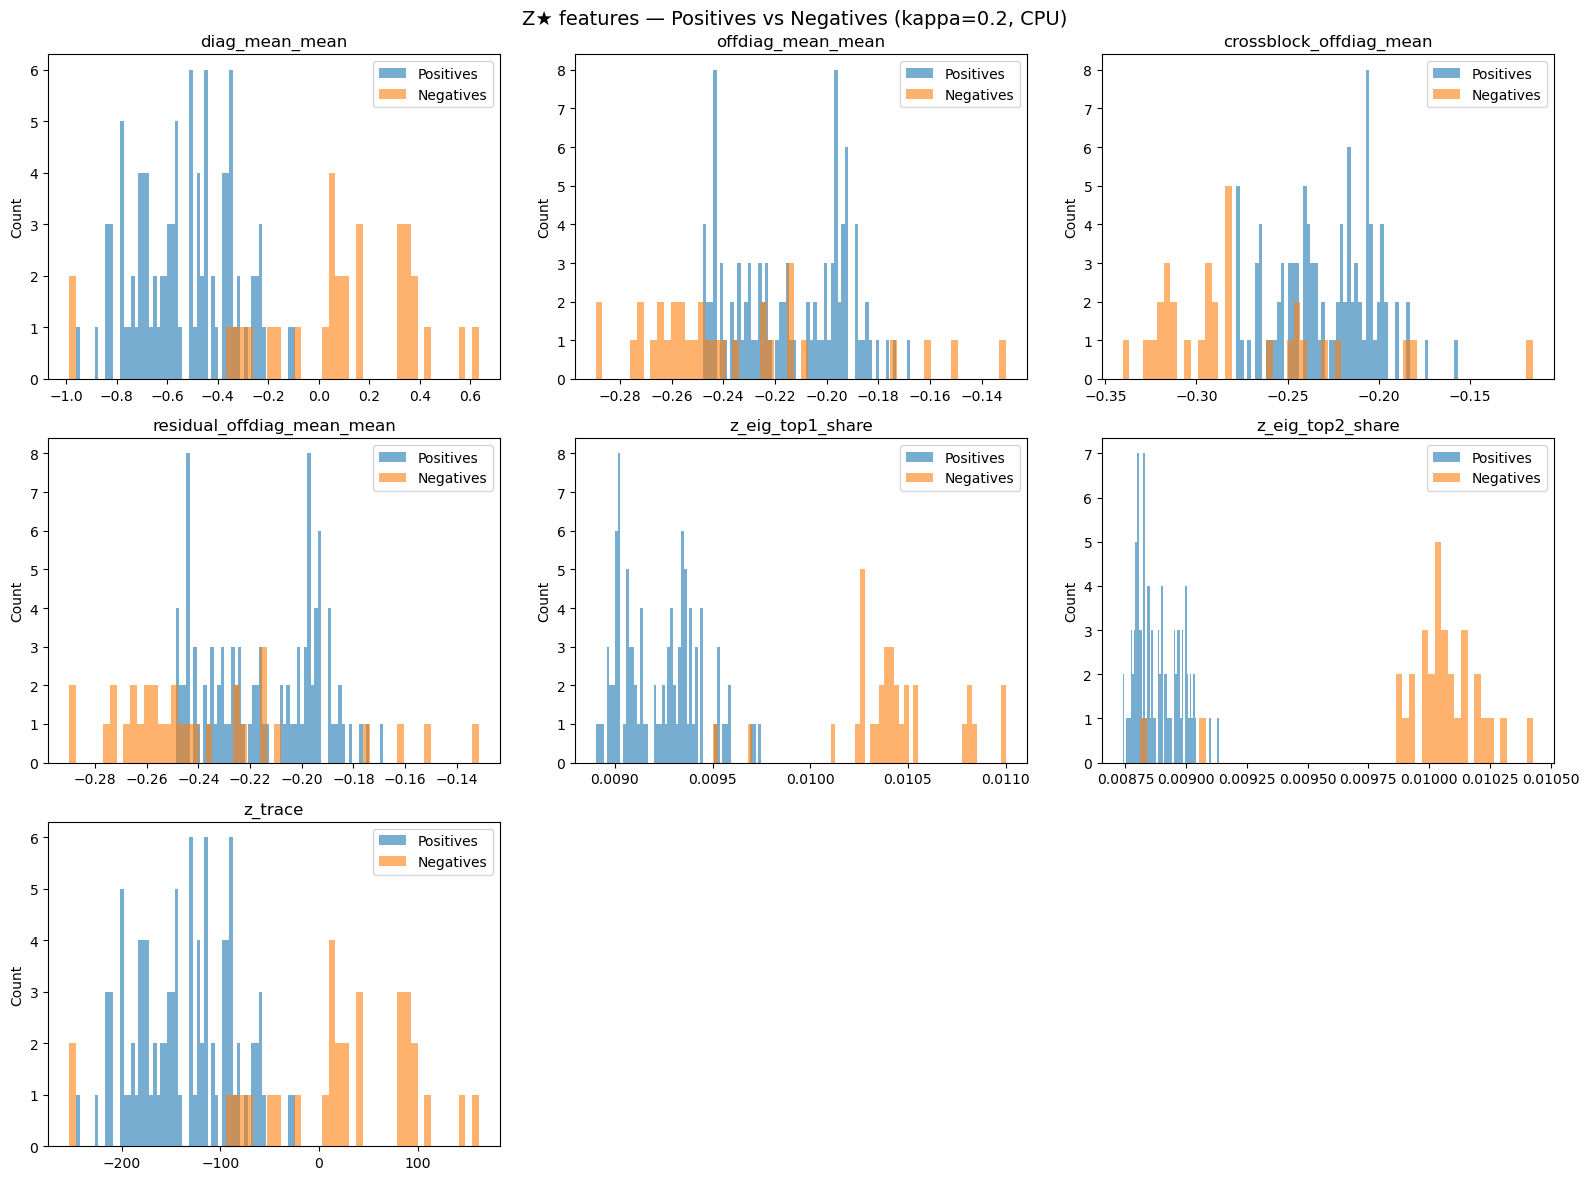

In [54]:
# --------------- Evaluation on Positives/Negatives ---------------


# -----------------------
# Helpers
# -----------------------



def compute_zstar_metrics_selected_cpu(Zstar_cpu, d, kappa=0.0, eps=1e-8):
    """
    Zstar_cpu: (B, 2d, 2d) on CPU
    d: latent dim (so matrix is 2d x 2d)
    kappa: identity weight used in cross-blocks (your identity_K)
    """
    Z = 0.5 * (Zstar_cpu + Zstar_cpu.transpose(-1, -2))
    B, n, _ = Z.shape
    assert n == 2*d, f"Expected n=2d, got n={n}, d={d}"

    # ---------- Original metrics ----------
    diag = torch.diagonal(Z, dim1=-2, dim2=-1)     # (B, n)
    diag_mean_mean = diag.mean(dim=-1)             # (B,)
    z_trace = diag.sum(dim=-1)                     # (B,)

    off = Z.clone()
    off.diagonal(dim1=-2, dim2=-1).zero_()
    offdiag_mean_mean = off.sum(dim=(-1, -2)) / (n*(n-1) + eps)

    evals = torch.linalg.eigvalsh(Z)               # (B, n)
    abs_evals = evals.abs()
    denom = abs_evals.sum(dim=-1) + eps
    top1 = abs_evals[:, -1] / denom
    top2 = abs_evals[:, -2] / denom

    # ---------- New metric 1: crossblock_offdiag_mean ----------
    Z_tph = Z[:, :d, d:]                           # (B, d, d)
    Z_tph_off = Z_tph.clone()
    Z_tph_off.diagonal(dim1=-2, dim2=-1).zero_()   # remove kappa*I contribution
    crossblock_offdiag_mean = Z_tph_off.sum(dim=(-1, -2)) / (d*(d-1) + eps)  # (B,)

    # ---------- New metric 2: residual_offdiag_mean_mean ----------
    # Build scaffold: [[I, kappa I], [kappa I, I]]
    I = torch.eye(d, device=Z.device).unsqueeze(0).expand(B, d, d)
    Z_scaffold = torch.zeros(B, 2*d, 2*d, device=Z.device)
    Z_scaffold[:, :d, :d] = I
    Z_scaffold[:, d:, d:] = I
    Z_scaffold[:, :d, d:] = kappa * I
    Z_scaffold[:, d:, :d] = kappa * I

    Z_res = Z - Z_scaffold
    Z_res_off = Z_res.clone()
    Z_res_off.diagonal(dim1=-2, dim2=-1).zero_()
    residual_offdiag_mean_mean = Z_res_off.sum(dim=(-1, -2)) / (n*(n-1) + eps)

    return {
        "diag_mean_mean": diag_mean_mean,
        "offdiag_mean_mean": offdiag_mean_mean,
        "z_eig_top1_share": top1,
        "z_eig_top2_share": top2,
        "z_trace": z_trace,
        "crossblock_offdiag_mean": crossblock_offdiag_mean,
        "residual_offdiag_mean_mean": residual_offdiag_mean_mean,
    }


def collect_metrics_cpu(boltz_loader, boltz_factoriser_cpu, gP_cpu, gH_cpu, d, kappa=0.0, max_batches=None):
    keys = [
        "diag_mean_mean",
        "offdiag_mean_mean",
        "z_eig_top1_share",
        "z_eig_top2_share",
        "z_trace",
        "crossblock_offdiag_mean",
        "residual_offdiag_mean_mean",
    ]
    out = {k: [] for k in keys}

    boltz_factoriser_cpu.eval()
    with torch.no_grad():
        for bi, boltz_batch in enumerate(boltz_loader):
            if max_batches is not None and bi >= max_batches:
                break

            z_boltz = boltz_batch["z"].float()
            L_p     = boltz_batch["pep_len"].long()
            L_alpha = boltz_batch["tcra_len"].long()
            L_beta  = boltz_batch["tcrb_len"].long()
            L_h     = boltz_batch["hla_len"].long()

            Zstar = boltz_factoriser_cpu(z_boltz, L_alpha, L_beta, L_p, L_h, gP_cpu, gH_cpu)

            metrics = compute_zstar_metrics_selected_cpu(Zstar, d=d, kappa=kappa)

            for k, v in metrics.items():
                out[k].append(v.numpy())

            del z_boltz, L_p, L_alpha, L_beta, L_h, Zstar, metrics

    for k in out:
        out[k] = np.concatenate(out[k], axis=0) if len(out[k]) else np.array([])
    return out


def plot_histograms_full(metrics_pos, metrics_neg, bins=60, suptitle="Z★ features — full dataset (CPU)"):
    keys = [
        "diag_mean_mean",
        "offdiag_mean_mean",
        "crossblock_offdiag_mean",
        "residual_offdiag_mean_mean",
        "z_eig_top1_share",
        "z_eig_top2_share",
        "z_trace",
    ]

    import matplotlib.pyplot as plt
    rows = 3
    cols = 3
    fig, axes = plt.subplots(rows, cols, figsize=(16, 12))
    axes = axes.flatten()

    for i, k in enumerate(keys):
        ax = axes[i]
        ax.hist(metrics_pos[k], bins=bins, alpha=0.6, label="Positives")
        ax.hist(metrics_neg[k], bins=bins, alpha=0.6, label="Negatives")
        ax.set_title(k)
        ax.set_ylabel("Count")
        ax.legend()

    for j in range(len(keys), rows*cols):
        axes[j].axis("off")

    fig.suptitle(suptitle, fontsize=14)
    plt.tight_layout()
    plt.show()


d = 128
kappa = 0.2  # identity_K you used

metrics_pos_full = collect_metrics_cpu(boltz_loader_eval, boltz_factoriser_cpu, gP_cpu, gH_cpu, d=d, kappa=kappa)
metrics_neg_full = collect_metrics_cpu(negatives_loader_eval, boltz_factoriser_cpu, gP_cpu, gH_cpu, d=d, kappa=kappa)


plot_histograms_full(metrics_pos_full, metrics_neg_full, bins=60,
                     suptitle=f"Z★ features — Positives vs Negatives (kappa={kappa}, CPU)")



# took 2 mins to plot 130 data points

Training Loop without Plots

In [ ]:
### ---- old functions to try and stabilise/regularise Zstar ----

# # Z spectral variance loss - similar to VICreg variance but for Zstar
# def Z_spectral_variance_loss(Z, target_ratio=1.5, iters=5, eps=1e-8):
#     """
#     Encourages the top eigenvalue not to dominate the spectrum.
#     target_ratio ≈ lambda_max / mean_lambda
#     """
#     B, n, _ = Z.shape

#     # Frobenius norm gives sum of squared eigenvalues
#     frob = Z.flatten(1).norm(dim=1)  # (B,)
#     mean_lambda = frob / (n ** 0.5 + eps)

#     # Power iteration for largest eigenvalue
#     v = torch.randn(B, n, 1, device=Z.device)
#     v = v / (v.norm(dim=1, keepdim=True) + eps)

#     for _ in range(iters):
#         v = torch.bmm(Z, v)
#         v = v / (v.norm(dim=1, keepdim=True) + eps)

#     Zv = torch.bmm(Z, v)
#     lambda_max = torch.bmm(v.transpose(1,2), Zv).squeeze(-1).squeeze(-1)
#     lambda_max = lambda_max.abs()

#     ratio = lambda_max / (mean_lambda + eps)

#     # Penalise if ratio too large
#     return torch.relu(ratio - target_ratio).pow(2).mean()


# # Z isotropy loss - similar to VICreg covariance but for Zstar
# def Z_isotropy_loss(Z, num_vec=4, eps=1e-8):
#     """
#     Penalises directional anisotropy of Z.
#     """
#     B, n, _ = Z.shape
#     norms = []

#     for _ in range(num_vec):
#         v = torch.randn(B, n, device=Z.device)
#         v = v / (v.norm(dim=1, keepdim=True) + eps)

#         Zv = torch.bmm(Z, v.unsqueeze(-1)).squeeze(-1)
#         norms.append(Zv.norm(dim=1))

#     norms = torch.stack(norms, dim=1)
#     return norms.var(dim=1).mean()


# # third regulariser - anchor Zstar norms to initial Zstar norms
# def Z_anchor_loss(Z, Z0_norm):
#     Znorm = Z.flatten(1).norm(dim=1).mean()
#     return (Znorm - Z0_norm).pow(2), Znorm
# # removing this as this anchors to the batch, so it can still run away and also only cares about magnitude 


# def operator_distill_loss(Z_student, Z_teacher):
#     """
#     Z_student, Z_teacher: (B, 2d, 2d)
#     Returns scalar: mean squared Frobenius distance per sample.
#     """
#     diff = Z_student - Z_teacher                      # (B, 2d, 2d)
#     per_sample = (diff * diff).flatten(1).mean(dim=1) # (B,) mean over entries
#     return per_sample.mean()                          # scalar


# def operator_distill_loss_rel(Z_student, Z_teacher, eps=1e-8):
#     # symmetrise both to compare in same space
#     Zs = 0.5 * (Z_student + Z_student.transpose(-1, -2))
#     Zt = 0.5 * (Z_teacher + Z_teacher.transpose(-1, -2))

#     diff2 = (Zs - Zt).pow(2).flatten(1).mean(dim=1)   # (B,)
#     base2 = (Zt).pow(2).flatten(1).mean(dim=1) + eps  # (B,)
#     return (diff2 / base2).mean()


# # introducce seoarate shape only operator
# def operator_shape_distill(Zs, Zt, eps=1e-8):
#     Zs = 0.5 * (Zs + Zs.transpose(-1, -2))
#     Zt = 0.5 * (Zt + Zt.transpose(-1, -2))

#     s = Zs.flatten(1)
#     t = Zt.flatten(1)

#     # cosine distance in operator space
#     s = s / (s.norm(dim=1, keepdim=True) + eps)
#     t = t / (t.norm(dim=1, keepdim=True) + eps)
#     return (1.0 - (s * t).sum(dim=1)).mean()


# # maybe won't include - to preserve histogram relationships
# def operator_stats_distill(Zs, Zt, eps=1e-8):
#     Zs = 0.5 * (Zs + Zs.transpose(-1, -2))
#     Zt = 0.5 * (Zt + Zt.transpose(-1, -2))

#     B, n, _ = Zs.shape
#     diag_mask = torch.eye(n, device=Zs.device).bool()
#     off_mask  = ~diag_mask

#     ds = Zs[:, diag_mask].mean(dim=1)
#     dt = Zt[:, diag_mask].mean(dim=1)
#     os = Zs[:, off_mask].mean(dim=1)
#     ot = Zt[:, off_mask].mean(dim=1)

#     # normalise by teacher scale so “mean” errors are comparable across runs
#     nt = Zt.flatten(1).norm(dim=1) + eps
#     return (((ds - dt)/nt)**2 + ((os - ot)/nt)**2).mean()



# # introduce separate magnitude only operator
# def operator_scale_distill(Zs, Zt, eps=1e-8):
#     Zs = 0.5 * (Zs + Zs.transpose(-1, -2))
#     Zt = 0.5 * (Zt + Zt.transpose(-1, -2))

#     ns = Zs.flatten(1).norm(dim=1) + eps
#     nt = Zt.flatten(1).norm(dim=1) + eps
#     # log ratio is symmetric + stable
#     return ((ns.log() - nt.log())**2).mean()

In [ ]:
# ##### ------------------ TRAINING WITH Z CONSTRAINTS ------------------

# # ---- Hyperparams ----
# B, L_T_pad, D = emb_T.shape
# rL = 8
# rD = 16
# d  = 128

# eps = 1e-8  # you use eps in normalisation; define it explicitly

# # rL = 8
# # rD = 16
# # d  = 128

# R_PH = 0.7
# gP = torch.tensor(R_PH ** 0.5, device=device)        # scalar gate
# gH = torch.tensor((1.0 - R_PH) ** 0.5, device=device)

# alpha = 1.0
# beta  = 1.0
# delta = 1.0
# gamma_var = 1.0

# # ---- Z regulariser weights ----
# lambda_anchor = 1e-6
# lambda_spec   = 0 #remove for  now
# lambda_iso    = 0 #remove for  now

# target_ratio = 1.5
# spec_iters = 5
# iso_num_vec = 4

# # ---- Z eigenvalue floor ----
# lambda_eigfloor = 1e-1    # start small; you may need 1e-1 if L_inv still runs away
# tau_eigfloor    = -5.0    # floor on smallest eigenvalue (tune this)

# # ---- Global max lengths ----
# L_T_max = train_dataset.emb_T.shape[1]
# L_P_max = train_dataset.emb_P.shape[1]
# L_H_max = train_dataset.emb_H.shape[1]

# # ---- Models ----
# tcr_factorised  = ESMFactorisedEncoder(D, rL, rD, d, L_max=L_T_max).to(device)
# pmhc_factorised = PMHCFactorisedEncoder(
#     D, rL, rD, d,
#     L_P_max=L_P_max,
#     L_H_max=L_H_max,
#     R_PH=R_PH
# ).to(device)

# boltz_factoriser = BoltzFactorised(
#     dB=128,
#     rB=16,
#     rT=8,
#     rPH=8,
#     d=d,
#     L_max=L_T_max_boltz,
#     L_PH_max=L_PH_max_boltz,
# ).to(device)

# optimizer = torch.optim.Adam([
#     {"params": tcr_factorised.parameters(),   "lr": 1e-3},
#     {"params": pmhc_factorised.parameters(),  "lr": 1e-3},
#     {"params": boltz_factoriser.parameters(), "lr": 1e-5},
# ])

# # ---- Anchored-norm state ----
# Z0_norm = None
# anchor_ema = 0.99  # your 0.99/0.01 EMA

# for step, (batch, boltz_batch) in enumerate(zip(train_loader, boltz_loader)):

#     print(step)

#     # -----------------------
#     # 1) SEQUENCE SIDE
#     # -----------------------
#     emb_T  = batch["emb_T"].to(device)
#     mask_T = batch["mask_T"].to(device)
#     emb_P  = batch["emb_P"].to(device)
#     mask_P = batch["mask_P"].to(device)
#     emb_H  = batch["emb_H"].to(device)
#     mask_H = batch["mask_H"].to(device)

#     zT  = tcr_factorised(emb_T, mask_T)                 # (B, d)
#     zT  = zT / (zT.norm(dim=-1, keepdim=True) + eps)

#     zPH = pmhc_factorised(emb_P, mask_P, emb_H, mask_H) # (B, d)
#     zPH = zPH / (zPH.norm(dim=-1, keepdim=True) + eps)

#     e_hat = torch.cat([zT, zPH], dim=-1)                # (B, 2d)

#     # -----------------------
#     # 2) BOLTZ SIDE
#     # -----------------------
#     z_boltz = boltz_batch["z"]
#     L_p     = boltz_batch["pep_len"]
#     L_alpha = boltz_batch["tcra_len"]
#     L_beta  = boltz_batch["tcrb_len"]
#     L_h     = boltz_batch["hla_len"]

#     # -----------------------
#     # 3) Base loss forward + Zstar
#     # -----------------------
#     loss_base, components, Zstar = non_contrastive_hamiltonian_loss(
#         zT=zT,
#         zPH=zPH,
#         e_hat=e_hat,
#         z_boltz_batch=z_boltz,
#         L_alpha=L_alpha,
#         L_beta=L_beta,
#         L_p=L_p,
#         L_h=L_h,
#         gP=gP,
#         gH=gH,
#         boltz_factoriser=boltz_factoriser,
#         alpha=alpha,
#         beta=beta,
#         delta=delta,
#         gamma_var=gamma_var,
#         eps=1e-4,
#         return_Zstar=True,
#         use_limit_Zstar=False,
#     )

#     # -----------------------
#     # 4) Z REGULARISERS (computed on SAME Zstar)
#     # -----------------------
#     # -----------------------
#     # 2b) Z-regularisers (ALL computed on the SAME Zstar)
#     # -----------------------

#     # (i) anchor loss (your existing)
#     L_anchor_raw, Znorm_mean = Z_anchor_loss(Zstar, Z0_norm if Z0_norm is not None else 0.0)
#     # initialise/update anchor target
#     if Z0_norm is None:
#         Z0_norm = Znorm_mean.detach()
#     else:
#         Z0_norm = 0.99 * Z0_norm + 0.01 * Znorm_mean.detach()

#     L_anchor = lambda_anchor * L_anchor_raw

#     # (ii) spectral ratio penalty (your existing)
#     L_spec = lambda_spec * Z_spectral_variance_loss(Zstar, target_ratio=target_ratio, iters=spec_iters)

#     # (iii) isotropy penalty (your existing)
#     L_iso = lambda_iso * Z_isotropy_loss(Zstar, num_vec=iso_num_vec)

#     # (iv) NEW: eigenvalue floor penalty (prevents runaway negative curvature)
#     L_eigfloor_raw, lam_min_mean, lam_min_min = Z_eig_floor_loss(Zstar, tau=tau_eigfloor)
#     L_eigfloor = lambda_eigfloor * L_eigfloor_raw

#     # Final loss
#     loss = loss_base + L_anchor + L_spec + L_iso + L_eigfloor


#     # log
#     Znorm_per_sample = Zstar.flatten(1).norm(dim=1)  # (B,)
#     components.update({
#         "L_total":       loss.item(),
#         "L_anchor":      L_anchor.item(),
#         "L_spec":        L_spec.item(),
#         "L_iso":         L_iso.item(),
#         "Znorm_mean":    Znorm_mean.item(),
#         "Z0_mean":       Z0_norm.item(),
#         "Znorm_max":     Znorm_per_sample.max().item(),
#         "Zstar_abs_mean": Zstar.abs().mean().item(),
#         "Zstar_max_abs":  Zstar.abs().max().item(),
#     })

#     # -----------------------
#     # 5) Pre-step prints
#     # -----------------------
#     if step == 0:
#         print("=== FIRST BATCH (pre-step) ===")
#         print(components)
#         print("zT norm mean:",  zT.norm(dim=-1).mean().item())
#         print("zPH norm mean:", zPH.norm(dim=-1).mean().item())

#     # -----------------------
#     # 6) Backward
#     # -----------------------
#     optimizer.zero_grad(set_to_none=True)
#     loss.backward()

#     if step == 0:
#         def grad_norm(m):
#             tot = 0.0
#             for p in m.parameters():
#                 if p.grad is not None:
#                     tot += p.grad.detach().float().norm().item()**2
#             return tot**0.5

#         print("grad ||tcr||:",   grad_norm(tcr_factorised))
#         print("grad ||pmhc||:",  grad_norm(pmhc_factorised))
#         print("grad ||boltz||:", grad_norm(boltz_factoriser))

#     # -----------------------
#     # 7) Debug: decompose quadratic into blocks (same Zstar)
#     # -----------------------
#     d_local = zT.shape[-1]
#     A_block = Zstar[:, :d_local, :d_local]
#     C_block = Zstar[:, :d_local, d_local:]
#     B_block = Zstar[:, d_local:, d_local:]

#     term_A = torch.einsum("bi,bij,bj->b", zT,  A_block, zT)
#     term_B = torch.einsum("bi,bij,bj->b", zPH, B_block, zPH)
#     term_C = 2.0 * torch.einsum("bi,bij,bj->b", zT, C_block, zPH)

#     with torch.no_grad():
#         print("term_A mean/max:", term_A.mean().item(), term_A.abs().max().item())
#         print("term_B mean/max:", term_B.mean().item(), term_B.abs().max().item())
#         print("term_C mean/max:", term_C.mean().item(), term_C.abs().max().item())

#         sym_err = (Zstar - Zstar.transpose(-1, -2)).abs().max().item()
#         print("Zstar symmetry max|Z-ZT|:", sym_err)
#         print("Znorm mean/max:", Znorm_mean.item(), Znorm_per_sample.max().item())
#         print("Z0 mean:", Z0_norm.item())

#     with torch.no_grad():
#         components["L_total_base"] = float(loss_base.item())
#         components["L_total"]      = float(loss.item())

#         components["L_anchor"]     = float(L_anchor.item())
#         components["L_spec"]       = float(L_spec.item())
#         components["L_iso"]        = float(L_iso.item())
#         components["L_eigfloor"]   = float(L_eigfloor.item())

#         components["lam_min_mean"] = lam_min_mean
#         components["lam_min_min"]  = lam_min_min

#         # Useful Z stats
#         Zflat = Zstar.flatten(1)
#         components["Zstar_abs_mean"] = float(Zstar.abs().mean().item())
#         components["Zstar_max_abs"]  = float(Zstar.abs().max().item())


#     print(components)

#     # -----------------------
#     # 8) Gradient clipping (after backward, before step)
#     # -----------------------
#     torch.nn.utils.clip_grad_norm_(boltz_factoriser.parameters(), max_norm=1.0) #was 10, but getting huge gradients

#     # -----------------------
#     # 9) Optimiser step
#     # -----------------------
#     optimizer.step()


0
=== FIRST BATCH (pre-step) ===
{'L_total_base': 0.8405921459197998, 'L_inv': -1.0792791843414307, 'L_var_T': 0.9572292566299438, 'L_var_PH': 0.962637722492218, 'L_cov_T': 9.38673224482045e-07, 'L_cov_PH': 3.3443009215261554e-06, 'L_total': 0.8416640758514404, 'L_anchor': 0.0010719199199229479, 'L_spec': 0.0, 'L_iso': 0.0, 'Znorm_mean': 32.74018859863281, 'Z0_mean': 32.74018859863281, 'Znorm_max': 33.624874114990234, 'Zstar_abs_mean': 0.07694073766469955, 'Zstar_max_abs': 1.5871294736862183}
zT norm mean: 1.0
zPH norm mean: 1.0
grad ||tcr||: 3.052505971247148
grad ||pmhc||: 2.700382748012117
grad ||boltz||: 9.091772057260457
term_A mean/max: 0.97406405210495 1.1129586696624756
term_B mean/max: 1.0660457611083984 1.3093974590301514
term_C mean/max: 0.11844874918460846 0.19927363097667694
Zstar symmetry max|Z-ZT|: 0.0
Znorm mean/max: 32.74018859863281 33.624874114990234
Z0 mean: 32.74018859863281
{'L_total_base': 0.8405921459197998, 'L_inv': -1.0792791843414307, 'L_var_T': 0.95722925662

##### Previous Z constraints and Limit Case

In [27]:
def non_contrastive_hamiltonian_loss(
    zT,
    zPH,
    e_hat,
    z_boltz_batch,
    L_alpha,
    L_beta,
    L_p,
    L_h,
    gP,
    gH,
    boltz_factoriser,
    alpha=1.0,
    beta=1.0,
    delta=1.0,
    gamma_var=1.0,
    eps=1e-4,
    return_Zstar=False,
    use_limit_Zstar=False,          # limit case
    lambda_Z=0.0,                   # regulariser weight
):
    """
    zT, zPH    : (B, d) TCR and pMHC embeddings (the two halves of e_hat)
    e_hat      : (B, 2d) concatenation [zT || zPH]
    z_boltz_*  : Boltz inputs, as in your BoltzFactorised.forward
    boltz_factoriser : instance of BoltzFactorised

    alpha : weight on invariance (Hamiltonian) term
    beta  : weight on variance terms
    delta : weight on covariance terms
    gamma_var : VICReg variance threshold (usually 1.0)
    """

    device = e_hat.device
    B, two_d = e_hat.shape
    d = two_d // 2


    # ---- 1) Boltz → Z★(n) for each sample ---- (B, 2d, 2d)
    
    # Try to simulate limit case - all identity matrixes
    if use_limit_Zstar:
        # paper limit: Z* = [[I, I],[I, I]]
        I = torch.eye(d, device=device).unsqueeze(0).expand(B, d, d)
        Zstar = torch.zeros(B, 2*d, 2*d, device=device)
        Zstar[:, :d, :d] = I
        Zstar[:, :d, d:] = I
        Zstar[:, d:, :d] = I
        Zstar[:, d:, d:] = I
    else:
        Zstar = boltz_factoriser(
        z_boltz_batch.to(device),
        L_alpha.to(device),
        L_beta.to(device),
        L_p.to(device),
        L_h.to(device),
        gP.to(device),
        gH.to(device),
    )  # (B, 2d, 2d)
        # symmetrise output every forward pass
        # even if this is done in the factoriser, doing it here is cheap and guarantees it
        Zstar = 0.5 * (Zstar + Zstar.transpose(-1, -2))
        

    # ---- 2) Hamiltonian proxy per sample: H^(n) = -1/2 e^T Z* e ----
    # einsum: 'bi,bij,bj->b' gives e^T Z* e for each n
    quad = torch.einsum("bi,bij,bj->b", e_hat, Zstar, e_hat)  # (B,)
    H = -0.5 * quad                                           # (B,)

    if use_limit_Zstar:
        cos = (zT * zPH).sum(dim=-1)          # (B,) since both unit norm
        H_expected = -1.0 - cos
        max_diff = (H - H_expected).abs().max().item()


    # Invariance term: average Hamiltonian over batch
    L_inv = H.mean()

    # ---- 3) Variance & covariance terms per block (TCR and pMHC) ----
    # zT and zPH are each (B, d)
    L_var_T  = vicreg_variance(zT,  gamma=gamma_var, eps=eps)
    L_var_PH = vicreg_variance(zPH, gamma=gamma_var, eps=eps)

    L_cov_T  = vicreg_covariance(zT,  eps=eps)
    L_cov_PH = vicreg_covariance(zPH, eps=eps)

    # ---- 4) Combine as in your equation (4) ----
    L_var_total = L_var_T + L_var_PH
    L_cov_total = L_cov_T + L_cov_PH

    L_total = (
        alpha * L_inv
        + beta * L_var_total
        + delta * L_cov_total
    )

    components = {
        "L_total":    L_total.item(),
        "L_inv":      L_inv.item(),
        "L_var_T":    L_var_T.item(),
        "L_var_PH":   L_var_PH.item(),
        "L_cov_T":    L_cov_T.item(),
        "L_cov_PH":   L_cov_PH.item(),
    }

    if use_limit_Zstar:
        components["H_expected_mean"] = H_expected.mean().item()
        components["H_actual_mean"]   = H.mean().item()
        components["H_max_abs_diff"]  = max_diff
        components["cos_mean"]        = cos.mean().item()
        components["H_min"]           = H.min().item()
        components["H_max"]           = H.max().item()


    if return_Zstar:
        return L_total, components, Zstar
    else:
        return L_total, components

    #return L_total, components


In [ ]:
##### ------------------ ADDING Z CONSTRAINTS ------------------

# ---- Hyperparams ----
B, L_T_pad, D = emb_T.shape
rL = 8
rD = 16
d  = 128

R_PH = 0.7
gP_scalar = R_PH ** 0.5
gH_scalar = (1.0 - R_PH) ** 0.5
gP = torch.tensor(gP_scalar, device=device)   # scalar gates
gH = torch.tensor(gH_scalar, device=device)

alpha = 1.0   # weight on invariance term
beta  = 1.0   # weight on var terms
delta = 1.0   # weight on cov terms

# ---- Get global max lengths for ESM factorised encoders ----
L_T_max = train_dataset.emb_T.shape[1]
L_P_max = train_dataset.emb_P.shape[1]
L_H_max = train_dataset.emb_H.shape[1]

# do this outside of the batch training loop so the weights are not reinitialised for each batch
tcr_factorised  = ESMFactorisedEncoder(D, rL, rD, d, L_max=L_T_max).to(device)
pmhc_factorised = PMHCFactorisedEncoder(
    D, rL, rD, d,
    L_P_max=L_P_max,
    L_H_max=L_H_max,
    R_PH=R_PH
).to(device)

# ---- Boltz factoriser (choose sensible hyperparams) ----
# dB = channel dimension of Boltz embeddings, e.g. boltz_batch["z"].shape[-1]
#dB   = boltz_loader[0][0].shape[-1]   # hard code, this line gives an erro
dB   = 128
rB   = 16     
rT   = 8       
rPH  = 8       
# Use values computed from manifest (defined in cell above)
L_T_max_boltz  = L_T_max_boltz  # max TCR length (alpha+beta) across manifest
L_PH_max_boltz = L_PH_max_boltz  # max pMHC length (pep+hla) across manifest


boltz_factoriser = BoltzFactorised(
    dB=dB,
    rB=rB,
    rT=rT,
    rPH=rPH,
    d=d,
    L_max=L_T_max_boltz,
    L_PH_max=L_PH_max_boltz,
).to(device)

# ---- Collect parameters & define optimiser ----
params = (
    list(tcr_factorised.parameters()) +
    list(pmhc_factorised.parameters()) +
    list(boltz_factoriser.parameters())
)

#optimizer = torch.optim.Adam(params, lr=1e-3)
optimizer = torch.optim.Adam([
    {"params": tcr_factorised.parameters(),  "lr": 1e-3},
    {"params": pmhc_factorised.parameters(), "lr": 1e-3},
    {"params": boltz_factoriser.parameters(), "lr": 1e-4},  # or 3e-4
])

# -----------------------
# Anchored-norm state - bound Zstar norms to initial Zstar norms
# -----------------------
lambda_anchor = 1e-2   # start here; if Z still ramps up try 1e-1, if it kills learning try 1e-3
Z0_norm = None         # will be set on first iteration (detached)

for step, (batch, boltz_batch) in enumerate(zip(train_loader, boltz_loader)):

    print(step)

    # ---- SEQUENCE SIDE ----
    emb_T  = batch["emb_T"].to(device)
    mask_T = batch["mask_T"].to(device)
    emb_P  = batch["emb_P"].to(device)
    mask_P = batch["mask_P"].to(device)
    emb_H  = batch["emb_H"].to(device)
    mask_H = batch["mask_H"].to(device)

    zT  = tcr_factorised(emb_T, mask_T)
    zT  = zT / (zT.norm(dim=-1, keepdim=True) + eps)

    zPH = pmhc_factorised(emb_P, mask_P, emb_H, mask_H)
    zPH = zPH / (zPH.norm(dim=-1, keepdim=True) + 1e-8)

    e_hat = torch.cat([zT, zPH], dim=-1)  # (B, 2d)

    # ---- BOLTZ SIDE ----
    z_boltz = boltz_batch["z"]
    L_p     = boltz_batch["pep_len"]
    L_alpha = boltz_batch["tcra_len"]
    L_beta  = boltz_batch["tcrb_len"]
    L_h     = boltz_batch["hla_len"]

    # -----------------------
    # 2) Loss forward (returns Zstar)
    # -----------------------
    loss, components, Zstar = non_contrastive_hamiltonian_loss(
        zT=zT,
        zPH=zPH,
        e_hat=e_hat,
        z_boltz_batch=z_boltz,
        L_alpha=L_alpha,
        L_beta=L_beta,
        L_p=L_p,
        L_h=L_h,
        gP=gP,
        gH=gH,
        boltz_factoriser=boltz_factoriser,
        alpha=alpha,
        beta=beta,
        delta=delta,
        gamma_var=1.0,
        return_Zstar=True,
        use_limit_Zstar=False,   # IMPORTANT: anchored norm is for the REAL case
        lambda_Z=0.0,
    )

    # -----------------------
    # 2b) Anchored-norm penalty on Zstar
    #     L_anchor = lambda * (||Z|| - ||Z0||)^2
    # -----------------------
    # Per-sample Frobenius norm (B,)
    Znorm = Zstar.flatten(1).norm(dim=1)

    # Initialise anchor on first iteration
    if Z0_norm is None:
        Z0_norm = Znorm.mean().detach()
    else:
        Z0_norm = 0.99 * Z0_norm + 0.01 * Znorm.mean().detach()

    L_anchor = lambda_anchor * (Znorm.mean() - Z0_norm).pow(2)

    #L_anchor = lambda_anchor * (Znorm - Z0_norm).pow(2).mean()

    # Add to total loss
    loss = loss + L_anchor

    # Track in components
    components["L_anchor"]   = L_anchor.item()
    components["Znorm_mean"] = Znorm.mean().item()
    components["Z0_mean"]    = Z0_norm.mean().item()
    components["Znorm_max"]  = Znorm.max().item()

    # -----------------------
    # 3) Pre-step prints
    # -----------------------
    if step == 0:
        print("=== FIRST BATCH (pre-step) ===")
        print(components)
        print("zT norm mean:",  zT.norm(dim=-1).mean().item())
        print("zPH norm mean:", zPH.norm(dim=-1).mean().item())

    # -----------------------------------------
    # 4) Backward pass
    # -----------------------------------------
    optimizer.zero_grad(set_to_none=True)
    loss.backward()

    if step == 0:
        def grad_norm(m):
            tot = 0.0
            for p in m.parameters():
                if p.grad is not None:
                    tot += p.grad.detach().float().norm().item()**2
            return tot**0.5

        print("grad ||tcr||:",   grad_norm(tcr_factorised))
        print("grad ||pmhc||:",  grad_norm(pmhc_factorised))
        print("grad ||boltz||:", grad_norm(boltz_factoriser))

    # -----------------------------------------
    # 5) Debug: decompose quadratic into blocks
    # -----------------------------------------
    d = zT.shape[-1]
    A_block = Zstar[:, :d, :d]
    C_block = Zstar[:, :d, d:]
    B_block = Zstar[:, d:, d:]

    term_A = torch.einsum("bi,bij,bj->b", zT,  A_block, zT)
    term_B = torch.einsum("bi,bij,bj->b", zPH, B_block, zPH)
    term_C = 2.0 * torch.einsum("bi,bij,bj->b", zT, C_block, zPH)

    with torch.no_grad():
        print("term_A mean/max:", term_A.mean().item(), term_A.abs().max().item())
        print("term_B mean/max:", term_B.mean().item(), term_B.abs().max().item())
        print("term_C mean/max:", term_C.mean().item(), term_C.abs().max().item())

        sym_err = (Zstar - Zstar.transpose(-1, -2)).abs().max().item()
        print("Zstar symmetry max|Z-ZT|:", sym_err)

        print("Zstar abs mean:", Zstar.abs().mean().item())
        print("Zstar max abs:",  Zstar.abs().max().item())
        print("Znorm mean/max:", Znorm.mean().item(), Znorm.max().item())
        print("Z0 mean:", Z0_norm.mean().item())

        # lam = approx_spectral_norm(Zstar, iters=3)
        # print("lambda_max approx mean/max:", lam.mean().item(), lam.max().item())

    print(components)

    # -----------------------------------------
    # 6) Gradient clipping
    # -----------------------------------------

    torch.nn.utils.clip_grad_norm_(
        boltz_factoriser.parameters(),
        max_norm=10.0
    )

    # 7) Optimiser step
    # -----------------------------------------
    optimizer.step()

0
=== FIRST BATCH (pre-step) ===
{'L_total': 5.370140075683594, 'L_inv': 3.4459939002990723, 'L_var_T': 0.9593005180358887, 'L_var_PH': 0.9648425579071045, 'L_cov_T': 7.847547749406658e-07, 'L_cov_PH': 2.0807594864891144e-06, 'L_anchor': 0.0, 'Znorm_mean': 1849.241455078125, 'Z0_mean': 1849.241455078125, 'Znorm_max': 1927.605712890625}
zT norm mean: 1.0
zPH norm mean: 1.0
grad ||tcr||: 216.6576049986074
grad ||pmhc||: 137.79171387229712
grad ||boltz||: 737.664848521035
term_A mean/max: -9.978446960449219 30.804811477661133
term_B mean/max: 0.6554511785507202 8.332881927490234
term_C mean/max: 2.431009531021118 9.845224380493164
Zstar symmetry max|Z-ZT|: 0.0
Zstar abs mean: 5.154047012329102
Zstar max abs: 58.64965057373047
Znorm mean/max: 1849.241455078125 1927.605712890625
Z0 mean: 1849.241455078125


NameError: name 'approx_spectral_norm' is not defined

In [ ]:
##### ------------------ LIMIT CASE ------------------

# ---- Hyperparams ----
B, L_T_pad, D = emb_T.shape
rL = 8
rD = 16
d  = 128

R_PH = 0.7
gP_scalar = R_PH ** 0.5
gH_scalar = (1.0 - R_PH) ** 0.5
gP = torch.tensor(gP_scalar, device=device)   # scalar gates
gH = torch.tensor(gH_scalar, device=device)

alpha = 1.0   # weight on invariance term
beta  = 1.0   # weight on var terms
delta = 1.0   # weight on cov terms

# ---- Get global max lengths for ESM factorised encoders ----
L_T_max = train_dataset.emb_T.shape[1]
L_P_max = train_dataset.emb_P.shape[1]
L_H_max = train_dataset.emb_H.shape[1]

# do this outside of the batch training loop so the weights are not reinitialised for each batch
tcr_factorised  = ESMFactorisedEncoder(D, rL, rD, d, L_max=L_T_max).to(device)
pmhc_factorised = PMHCFactorisedEncoder(
    D, rL, rD, d,
    L_P_max=L_P_max,
    L_H_max=L_H_max,
    R_PH=R_PH
).to(device)

# ---- Boltz factoriser (choose sensible hyperparams) ----
# dB = channel dimension of Boltz embeddings, e.g. boltz_batch["z"].shape[-1]
#dB   = boltz_loader[0][0].shape[-1]   # hard code, this line gives an erro
dB   = 128
rB   = 16     
rT   = 8       
rPH  = 8       
# Use values computed from manifest (defined in cell above)
L_T_max_boltz  = L_T_max_boltz  # max TCR length (alpha+beta) across manifest
L_PH_max_boltz = L_PH_max_boltz  # max pMHC length (pep+hla) across manifest


boltz_factoriser = BoltzFactorised(
    dB=dB,
    rB=rB,
    rT=rT,
    rPH=rPH,
    d=d,
    L_max=L_T_max_boltz,
    L_PH_max=L_PH_max_boltz,
).to(device)

# ---- Collect parameters & define optimiser ----
params = (
    list(tcr_factorised.parameters()) +
    list(pmhc_factorised.parameters()) +
    list(boltz_factoriser.parameters())
)

optimizer = torch.optim.Adam(params, lr=1e-3)

#for batch, boltz_batch in zip(train_loader, boltz_loader):
for step, (batch, boltz_batch) in enumerate(zip(train_loader, boltz_loader)):

    print(step)

    # ---- SEQUENCE SIDE ----
    emb_T  = batch["emb_T"].to(device)      # (B, L_T_pad, D)
    mask_T = batch["mask_T"].to(device)
    emb_P  = batch["emb_P"].to(device)
    mask_P = batch["mask_P"].to(device)
    emb_H  = batch["emb_H"].to(device)
    mask_H = batch["mask_H"].to(device)

    # Factorised encoders
    zT  = tcr_factorised(emb_T, mask_T)                 # (B, d)
    zT  = zT / (zT.norm(dim=-1, keepdim=True) + eps)

    zPH = pmhc_factorised(emb_P, mask_P, emb_H, mask_H) # (B, d)
    zPH = zPH / (zPH.norm(dim=-1, keepdim=True) + 1e-8)

    e_hat = torch.cat([zT, zPH], dim=-1)                # (B, 2d)

    # ---- BOLTZ SIDE ----
    z_boltz = boltz_batch["z"]       # (B, L_pad, L_pad, dB)  <-- correct key
    L_p     = boltz_batch["pep_len"]
    L_alpha = boltz_batch["tcra_len"]
    L_beta  = boltz_batch["tcrb_len"]
    L_h     = boltz_batch["hla_len"]

    # -----------------------
    # 2) Loss forward (also returns Zstar for debugging)
    # -----------------------


    # add 'Zstar' as an argument if you want to return it
    loss, components, Zstar = non_contrastive_hamiltonian_loss(
    zT=zT,
    zPH=zPH,
    e_hat=e_hat,
    z_boltz_batch=z_boltz,
    L_alpha=L_alpha,
    L_beta=L_beta,
    L_p=L_p,
    L_h=L_h,
    gP=gP,
    gH=gH,
    boltz_factoriser=boltz_factoriser,
    alpha=alpha,
    beta=beta,
    delta=delta,
    gamma_var=1.0,
    return_Zstar=True,
    use_limit_Zstar=True,
    lambda_Z=0.0,
    )
    
    # -----------------------
    # 3) Pre-step prints (same forward pass)
    # -----------------------
    if step == 0:
        print("=== FIRST BATCH (pre-step) ===")
        print(components)
        print("zT norm mean:",  zT.norm(dim=-1).mean().item())
        print("zPH norm mean:", zPH.norm(dim=-1).mean().item())

    # -----------------------------------------
    # 4) Backward pass (compute gradients)
    # -----------------------------------------
    optimizer.zero_grad(set_to_none=True)
    loss.backward()

    # Print gradient norms (must be after backward)
    if step == 0:
        def grad_norm(m):
            tot = 0.0
            for p in m.parameters():
                if p.grad is not None:
                    tot += p.grad.detach().float().norm().item()**2
            return tot**0.5

        print("grad ||tcr||:",   grad_norm(tcr_factorised))
        print("grad ||pmhc||:",  grad_norm(pmhc_factorised))
        print("grad ||boltz||:", grad_norm(boltz_factoriser))

    # -----------------------------------------
    # 5) Debug: decompose quadratic into blocks
    #    (this uses the SAME Zstar as forward)
    # -----------------------------------------
    d = zT.shape[-1]
    A_block = Zstar[:, :d, :d]
    C_block = Zstar[:, :d, d:]
    B_block = Zstar[:, d:, d:]

    term_A = torch.einsum("bi,bij,bj->b", zT,  A_block, zT)
    term_B = torch.einsum("bi,bij,bj->b", zPH, B_block, zPH)
    term_C = 2.0 * torch.einsum("bi,bij,bj->b", zT, C_block, zPH)

    with torch.no_grad():
        print("term_A mean/max:", term_A.mean().item(), term_A.abs().max().item())
        print("term_B mean/max:", term_B.mean().item(), term_B.abs().max().item())
        print("term_C mean/max:", term_C.mean().item(), term_C.abs().max().item())

        sym_err = (Zstar - Zstar.transpose(-1, -2)).abs().max().item()
        print("Zstar symmetry max|Z-ZT|:", sym_err)

        print("Zstar abs mean:", Zstar.abs().mean().item())
        print("Zstar max abs:",  Zstar.abs().max().item())

    print(components)

    # -----------------------------------------
    # 6) Optimiser step (update parameters)
    # -----------------------------------------
    optimizer.step()



0
=== FIRST BATCH (pre-step) ===
{'L_total': 1.0994528532028198, 'L_inv': -0.8148517608642578, 'L_var_T': 0.9488778114318848, 'L_var_PH': 0.9654240608215332, 'L_cov_T': 1.3895734127800097e-06, 'L_cov_PH': 1.3311723705555778e-06, 'H_expected_mean': -0.814851701259613, 'H_actual_mean': -0.8148517608642578, 'H_max_abs_diff': 1.1920928955078125e-07, 'cos_mean': -0.18514826893806458, 'H_min': -0.8685272932052612, 'H_max': -0.7375632524490356}
zT norm mean: 1.0
zPH norm mean: 1.0
grad ||tcr||: 2.022240165751352
grad ||pmhc||: 1.7334930506630921
grad ||boltz||: 0.0
term_A mean/max: 1.0 1.000000238418579
term_B mean/max: 1.0 1.0000001192092896
term_C mean/max: -0.37029653787612915 0.5248736143112183
Zstar symmetry max|Z-ZT|: 0.0
Zstar abs mean: 0.0078125
Zstar max abs: 1.0
{'L_total': 1.0994528532028198, 'L_inv': -0.8148517608642578, 'L_var_T': 0.9488778114318848, 'L_var_PH': 0.9654240608215332, 'L_cov_T': 1.3895734127800097e-06, 'L_cov_PH': 1.3311723705555778e-06, 'H_expected_mean': -0.814851

In [39]:
# #dB   = boltz_loader[0][0].shape[-1]   # or hard-code if you know it

# #boltz_loader['z'][0][0]

# B, L_T_pad, D = emb_T.shape

# print(B, L_T_pad, D)

# # Get first batch from DataLoader to inspect shape
# # DataLoaders are iterables, not subscriptable - use next(iter(...)) to get a batch
# first_batch = next(iter(boltz_loader))
# dB = first_batch['z'].shape[-1]   # Get channel dimension from the 'z' tensor
# print(f"dB (Boltz channel dimension): {dB}")
# print(f"First batch 'z' shape: {first_batch['z'].shape}")
# print(f"First element of first batch: {first_batch['z'][0][0]}")

##### Old code

In [ ]:
# try for loop for one batch (break at the end)
for tcr_batch, pep_batch, hla_batch, boltz_batch in zip(tcr_loader, pep_loader, hla_loader, boltz_loader):
    




    break

# to load one batch from each loader on CPU took 6.6s

{'masked_input_ids': tensor([[ 0, 32, 17,  ...,  1,  1,  1],
        [ 0,  6, 17,  ...,  1,  1,  1],
        [ 0,  6, 17,  ...,  1,  1,  1],
        ...,
        [ 0,  6, 32,  ...,  1,  1,  1],
        [ 0, 32, 17,  ...,  1,  1,  1],
        [ 0,  6, 32,  ...,  2,  1,  1]]), 'labels': tensor([[-100,    6, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100],
        [-100, -100, -100,  ..., -100, -100, -100],
        ...,
        [-100, -100,   17,  ..., -100, -100, -100],
        [-100,    6, -100,  ..., -100, -100, -100],
        [-100, -100,   17,  ..., -100, -100, -100]]), 'attention_mask': tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 1, 0, 0]]), 'clean_input_ids': tensor([[ 0,  6, 17,  ...,  1,  1,  1],
        [ 0,  6, 17,  ...,  1,  1,  1],
        [ 0,  6, 17,  ...,  1,  1,  1],
        ...

In [21]:
# Testing on one batch so far
# 1. Pick a batch and get token tensors and masks

tcr_batch = next(iter(tcr_loader))
pep_batch = next(iter(pep_loader))
hla_batch = next(iter(hla_loader))

tcr_ids = tcr_batch['clean_input_ids']
tcr_mask = tcr_batch['attention_mask']

pep_ids = pep_batch['clean_input_ids']
pep_mask = pep_batch['attention_mask']

hla_ids = hla_batch['clean_input_ids']
hla_mask = hla_batch['attention_mask']

# Unsqueze to make the right dims
mT = tcr_mask.unsqueeze(-1).float()   # (B, L_T_pad, 1)
mP = pep_mask.unsqueeze(-1).float()   # (B, L_P_pad, 1)
mH = hla_mask.unsqueeze(-1).float()   # (B, L_H_pad, 1)


#B = tcr_ids.size(0)

# ---- TIME ESM FORWARDS ----
t0 = time.perf_counter()
# Call the BASE model inside the LoRA wrapper
with torch.no_grad():
    out_T = tcr_encoder.model.forward(sequence_tokens=tcr_ids)
    out_P = peptide_encoder.model.forward(sequence_tokens=pep_ids)
    out_H = hla_encoder.model.forward(sequence_tokens=hla_ids)
t1 = time.perf_counter()
print(f"ESM forwards (T+P+H) took: {t1 - t0:.3f} s")


# Some ESMC builds expose .embeddings; otherwise take last hidden state
emb_T = out_T.embeddings 
emb_P = out_P.embeddings 
emb_H = out_H.embeddings

# it is true that the shape of the embeddings is (B, L_pad, D)
# takes 18 seconds on CPU to do 24 embeddings

# Shapes
# is this B the same as the above B I defined?
B, L_T_pad, D = emb_T.shape

rL = 8
rD = 16
d  = 128      # shared d

# true length estimates
L_T_true = tcr_mask.sum(dim=1)
L_T_max  = L_T_true.max()

L_P_true = pep_mask.sum(dim=1)
L_P_max  = L_P_true.max()

L_H_true = hla_mask.sum(dim=1)
L_H_max  = L_H_true.max()

# Encoders
tcr_encoder = ESMFactorisedEncoder(D, rL, rD, d, L_max=L_T_max).to(device)

pmhc_encoder = PMHCFactorisedEncoder(
    D, rL, rD, d,
    L_P_max=L_P_max,
    L_H_max=L_H_max,
    R_PH=0.7
).to(device)

# Forward
zT = tcr_encoder(emb_T, tcr_mask)                    # (B, d)
zT = zT / (zT.norm(dim=-1, keepdim=True) + eps)          # normalise TCR

zPH = pmhc_encoder(emb_P, pep_mask, emb_H, hla_mask) # (B, d)

# Final fused representation
e_hat = torch.cat([zT, zPH], dim=-1)                     # (B, 2d)


# takes 18s for 1 batch :/ 

ESM forwards (T+P+H) took: 17.520 s


#### Code below is old code pre reorganisation and full loss function building

##### a) Factorisation/Projection for ESMC Encoders
- N.B. From next cell onwards, need to reconfigure to do for loop for all batches

In [17]:
# 1. Pick a batch and get token tensors and masks

tcr_batch = next(iter(tcr_loader))
pep_batch = next(iter(pep_loader))
hla_batch = next(iter(hla_loader))

tcr_ids = tcr_batch['clean_input_ids']
tcr_mask = tcr_batch['attention_mask']

pep_ids = pep_batch['clean_input_ids']
pep_mask = pep_batch['attention_mask']

hla_ids = hla_batch['clean_input_ids']
hla_mask = hla_batch['attention_mask']

# Unsqueze to make the right dims
mT = tcr_mask.unsqueeze(-1).float()   # (B, L_T_pad, 1)
mP = pep_mask.unsqueeze(-1).float()   # (B, L_P_pad, 1)
mH = hla_mask.unsqueeze(-1).float()   # (B, L_H_pad, 1)


B = tcr_ids.size(0)


In [18]:
# Call the BASE model inside the LoRA wrapper
with torch.no_grad():
    out_T = tcr_encoder.model.forward(sequence_tokens=tcr_ids)
    out_P = peptide_encoder.model.forward(sequence_tokens=pep_ids)
    out_H = hla_encoder.model.forward(sequence_tokens=hla_ids)

# Some ESMC builds expose .embeddings; otherwise take last hidden state
emb_T = out_T.embeddings 
emb_P = out_P.embeddings 
emb_H = out_H.embeddings

# it is true that the shape of the embeddings is (B, L_pad, D)
# takes 18 seconds on CPU to do 24 embeddings

In [ ]:
# Think this cell is included in the below
# # maximum true tcr length 
# L_T_true = tcr_mask.sum(dim=1)
# L_T_max = L_T_true.max()

# # maximum true peptide length 
# L_P_true = pep_mask.sum(dim=1)
# L_P_max = L_P_true.max()

# # maximum true HLA length 
# L_H_true = hla_mask.sum(dim=1)
# L_H_max = L_H_true.max()

In [20]:
# Factorised Encoder to get z_T and Z_pMHC
# z = vec(A^TXB)H
# X - (B, L_pad, D)
# B - (D, rD)
# A - (L_pad, rL)
# H - (rD * rL, d)


eps = 1e-8

class ESMFactorisedEncoder(nn.Module):
    def __init__(self, D, rL, rD, d, L_max):
        """
        D    : ESM embedding dim (e.g. 960)
        rL   : positional rank
        rD   : channel rank
        d    : latent dim
        L_max: max true length for this modality in the batch
        """
        super().__init__()
        self.D   = D
        self.rL  = rL
        self.rD  = rD
        self.d   = d
        self.L_max = L_max

        # Channel mixing: D -> rD
        self.B_c = nn.Parameter(torch.empty(D, rD))
        nn.init.xavier_uniform_(self.B_c)

        # Positional mixing: positions 0..L_max-1 -> rL
        self.A_c = nn.Parameter(torch.empty(L_max, rL))
        nn.init.xavier_uniform_(self.A_c)

        # Final map: (rL * rD) -> d
        self.H_c = nn.Parameter(torch.empty(rL * rD, d))
        nn.init.xavier_uniform_(self.H_c)

    def forward(self, emb, mask):
        """
        emb  : (B, L_pad, D) token embeddings
        mask : (B, L_pad)   1 = real token, 0 = pad
        returns z : (B, d)
        """
        device = emb.device
        B, L_pad, D = emb.shape
        assert D == self.D

        # Compute true lengths
        L_true = mask.sum(dim=1)            # (B,)
        z_list = []

        for b in range(B):
            Lb = int(L_true[b].item())
            if Lb == 0:
                # Degenerate case: no tokens -> zero vector
                z_b = torch.zeros(self.d, device=device)
                z_list.append(z_b)
                continue

            Xb = emb[b, :Lb, :]                      # (Lb, D)
            mb = mask[b, :Lb].unsqueeze(-1).float()  # (Lb, 1)
            Xb = Xb * mb                             # (Lb, D)

            # 1) Channel compression: D -> rD
            Yb = Xb @ self.B_c                       # (Lb, rD)

            # 2) Positional compression: Lb -> rL
            A_pos = self.A_c[:Lb, :]                 # (Lb, rL)
            Ub = A_pos.T @ Yb                        # (rL, rD)

            # 3) Flatten and map to latent d
            Ub_flat = Ub.reshape(-1)                 # (rL * rD,)
            z_b = Ub_flat @ self.H_c                 # (d,)

            # 4) Normalise (optional; you can drop this if you want magnitude to carry info)
            #z_b = z_b / (z_b.norm() + eps)
            #normalise after function because need to combine p and hla first

            z_list.append(z_b)

        z = torch.stack(z_list, dim=0)               # (B, d)
        return z


In [21]:
# Shape
B, L_T_pad, D = emb_T.shape

# Latent ranks and final dimension (hyperparameters)
rL = 8      # positional rank for TCR (tunable)
rD = 16     # channel rank for TCR (tunable)
d    = 128    # final latent dimension (same d as in Z*)

# ratio of peptide to HLA (hyperparameter)
#R = 0.7
# Epsilon for numerical stability
eps=1e-8

# maximum true lenghts of the sequences
# maximum true tcr length 
L_T_true = tcr_mask.sum(dim=1)
L_T_max = L_T_true.max()
# maximum true peptide length 
L_P_true = pep_mask.sum(dim=1)
L_P_max = L_P_true.max()
# maximum true HLA length 
L_H_true = hla_mask.sum(dim=1)
L_H_max = L_H_true.max()


tcr_encoder_new = ESMFactorisedEncoder(D, rL, rD, d, L_max=L_T_max).to(device)
pep_encoder_new = ESMFactorisedEncoder(D, rL, rD, d, L_max=L_P_max).to(device)
hla_encoder_new = ESMFactorisedEncoder(D, rL, rD, d, L_max=L_H_max).to(device)

# when you call module(), you are calling the forward method (PyTorch convention)
zT = tcr_encoder_new(emb_T, tcr_mask)
zP = pep_encoder_new(emb_P, pep_mask)
zH = hla_encoder_new(emb_H, hla_mask)

# normalise T as we are not gating this
zT = zT / (zT.norm(dim=-1, keepdim=True) + eps)



In [ ]:
# change to what Barbara suggested in meeting - scale within the projection learning?

R_PH = 0.7  # peptide gets more weight

gP = (R_PH ** 0.5)          # scalar
gH = ((1.0 - R_PH) ** 0.5)  # scalar

gP_t = torch.tensor(gP, device=device)
gH_t = torch.tensor(gH, device=device)

# zP, zH: (B, d)
zPH = gP_t * zP + gH_t * zH      # (B, d)
# Optionally normalise:
zPH = zPH / (zPH.norm(dim=-1, keepdim=True) + eps)

# concatenate into e_hat
e_hat = torch.cat([zT, zPH], dim=-1)



In [23]:
# next step to apply non linear layers (potentially ReLU as middle layers, as long as the end is linear transformation and can learn negative values)

In [ ]:
# structure

##### Get Boltz Embeddings

In [ ]:
# # get Boltz embeddings
# file_path = '/home/natasha/multimodal_model/outputs/boltz_runs/positives/pair_000/boltz_results_pair_000/predictions/pair_000/embeddings_pair_000.npz'
# manifest_path = '/home/natasha/multimodal_model/data/manifests/boltz_100_manifest.csv'

In [ ]:
print(os.getcwd())

home = '/home/natasha/multimodal_model'
manifest_path = os.path.join(home, 'data', 'manifests', 'boltz_100_manifest.csv')
# positive_manifest_path = os.path.join(home, 'data', 'manifests', 'boltz_100_manifest.csv')
# negative_manifest_path = os.path.join(home, 'data', 'negative_manifests', 'boltz_100_manifest.csv')
#print(manifest_path)

/home/natasha/multimodal_model/scripts/train
/home/natasha/multimodal_model/data/manifests/boltz_100_manifest.csv


In [26]:
class BoltzDataset(Dataset):
    """
    Dataset for loading Boltz z-embeddings one by one,
    with chain lengths from the manifest.
    Each pair has its own .npz file.
    ORIGINAL VERSION - returns numpy arrays
    """
    def __init__(self, manifest_path, base_path):
        self.manifest = pd.read_csv(manifest_path)
        self.base_path = base_path

    def __len__(self):
        return len(self.manifest)

    def __getitem__(self, idx):
        yaml_rel_path = self.manifest.iloc[idx]['yaml_path']
        pair_id = os.path.splitext(os.path.basename(yaml_rel_path))[0]
        emb_path = os.path.join(
            self.base_path,
            'outputs',
            'boltz_runs',
            'positives',
            pair_id,
            f'boltz_results_{pair_id}',
            'predictions',
            pair_id,
            f'embeddings_{pair_id}.npz'
        )
        with np.load(emb_path) as arr:
            z = arr['z']  # Returns numpy array as-is
        pep_len = self.manifest.iloc[idx]['pep_len']
        tcra_len = self.manifest.iloc[idx]['tcra_len']
        tcrb_len = self.manifest.iloc[idx]['tcrb_len']
        hla_len = self.manifest.iloc[idx]['hla_len']
        return z, pep_len, tcra_len, tcrb_len, hla_len


def boltz_collate_fn(batch):
    """
    Uses numpy for padding, then converts to torch at the end
    """
    zs, pep_lens, tcra_lens, tcrb_lens, hla_lens = zip(*batch)
    # Each z has shape [sum_of_lengths, sum_of_lengths, dim] or [1, sum_of_lengths, sum_of_lengths, dim]
    # Pad zs to max shape with zeros and stack into tensor
    zs = [np.squeeze(z, axis=0) for z in zs]
    max_len = max(z.shape[0] for z in zs)
    # get channel dimension number from first z
    dim = zs[0].shape[-1]
    padded_zs = np.zeros((len(zs), max_len, max_len, dim), dtype=zs[0].dtype)
    for i, z in enumerate(zs):
        l = z.shape[0]
        padded_zs[i, :l, :l, :] = z
    zs = torch.from_numpy(padded_zs).float()  # or .to(device)
    
    return {
        "z": zs,  # batch of z arrays, each possibly of different shape
        "pep_len": np.array(pep_lens),
        "tcra_len": np.array(tcra_lens),
        "tcrb_len": np.array(tcrb_lens),
        "hla_len": np.array(hla_lens),
    }

# Example usage with original version:
dataset_original = BoltzDataset(manifest_path, home)
dataloader_original = DataLoader(
    dataset_original, batch_size=8, shuffle=True, collate_fn=boltz_collate_fn
)


batch = next(iter(dataloader_original))
print("Batch z shapes:", [z.shape for z in batch["z"]])
print("Pep lengths:", batch["pep_len"])

# 5.6s to load 100 pairs
# 56 s to load 1000 pairs
# 560 s to load 10000 pairs (9 mins)
# 5600 s to load 100000 pairs (16 mins)

Batch z shapes: [torch.Size([604, 604, 128]), torch.Size([604, 604, 128]), torch.Size([604, 604, 128]), torch.Size([604, 604, 128]), torch.Size([604, 604, 128]), torch.Size([604, 604, 128]), torch.Size([604, 604, 128]), torch.Size([604, 604, 128])]
Pep lengths: [ 9  9 10  9  9 10  9 10]


In [30]:
L_T = batch["tcra_len"] + batch["tcrb_len"]
L_P = batch["pep_len"]
L_H = batch["hla_len"]

L_T_max = max(L_T)
L_P_max = max(L_P)
L_H_max = max(L_H)

print(L_T_max, L_P_max, L_H_max, batch['tcra_len'], batch['tcrb_len'], batch['pep_len'], batch['hla_len'])

230 10 365 [112 114 112 110 113 112 113 112] [116 116 113 114 115 114 115 117] [ 9  9 10  9  9 10  9 10] [362 365 365 365 365 365 365 365]


In [ ]:
# Factorisation Z

for i in range(len(batch["z"])):
    L_T_max = batch["tcra_len"][i]
    L_P_max = batch["pep_len"][i]
    L_H_max = batch["hla_len"][i]



dB  = 128 # dimension of Boltz embeddings
rB  = 16 # Boltz channel rank
rT  = 8 # TCR positional rank
rPH = 8 # pMHC positional rank

B_Z = torch.nn.Parameter(torch.empty(dB, rB))
nn.init.xavier_uniform_(B_Z)


L_T_max = int()

In [ ]:
class BoltzFactorised(nn.Module):
    """
    Factorised Boltz embeddings for projection into latent shared space before NC loss

    Inputs:
    - z_boltz: (B, L_pad, L_pad, d_boltz) full Boltz z for the batch
    - L_alpha, L_beta, L_p, L_h: (B,) lengths of the TCR alpha, TCR beta, peptide, HLA
    - gP, gH: (B,) scalar or (B,) peptide/HLA gates in [0,1], norm-preserving in quadrature???? As in, gP**2 + gH**2 = 1

    Outputs:
    - Zstar_batch: (B, 2d, 2d) operator acting on e_hat_t, e_hat_pmc in R^2d
    """
    def __init__(self, dB, rB, rT, rPH, d, L_max, L_PH_max):
        """
        dB      : channel dimension of Boltz embeddings
        rB      : rank of Boltz channel factorisation
        rT      : rank of TCR positional encoding
        rPH     : rank of pMHC positional encoding
        d       : latent dimension of shared space
        L_T_max   : maximum length of any sequence in the batch
        L_PH_max: maximum length of any pMHC sequence in the batch
        """
        super().__init__()
        self.dB     = dB
        self.rB     = rB
        self.rT     = rT
        self.rPH    = rPH
        self.d      = d
        self.L_T_max  = L_max
        self.L_PH_max = L_PH_max

        # ---- 1) Channel mixing: dB -> rB ---- 
        self.B_Z = torch.nn.Parameter(torch.empty(dB, rB))
        nn.init.xavier_uniform_(self.B_Z)

        # ---- 2)a) TCR positional encoding: rT -> rT ---- 
        self.A_T = torch.nn.Parameter(torch.empty(L_T_max, rT))
        nn.init.xavier_uniform_(self.A_T)

        # ---- 2)b) pMHC positional encoding: rPH -> rPH ---- 
        self.A_PH = torch.nn.Parameter(torch.empty(L_PH_max, rPH))
        nn.init.xavier_uniform_(self.A_PH)

        # ---- 3) Learnable maps from factorised z (r* x r* x rB) -> d x d ---- 
        # flatten sizes for each block
        n_TT   = rT  * rT  * rB
        n_TPH  = rT  * rPH * rB
        n_PHT  = rPH * rT  * rB
        n_PHPH = rPH * rPH * rB
        dd     = d * d

        self.H_TT   = nn.Parameter(torch.empty(n_TT,   dd))
        self.H_TPH  = nn.Parameter(torch.empty(n_TPH,  dd))
        self.H_PHT  = nn.Parameter(torch.empty(n_PHT,  dd))
        self.H_PHPH = nn.Parameter(torch.empty(n_PHPH, dd))

        nn.init.xavier_uniform_(self.H_TT)
        nn.init.xavier_uniform_(self.H_TPH)
        nn.init.xavier_uniform_(self.H_PHT)
        nn.init.xavier_uniform_(self.H_PHPH)

        # ---- 4) Final linear layer: d -> d ---- 
        self.W_out = nn.Parameter(torch.empty(d, d))
        nn.init.xavier_uniform_(self.W_out)
    
    def _get_gate_scalar(self, g, b):
        """
        Helper: allow g to be a scalar tensor () or per-sample tensor (B,).
        Returns a Python float for sample b.
        """
        if g.dim() == 0:
            return float(g.item())
        else:
            return float(g[b].item())

    def forward(self, z_boltz, L_alpha, L_beta, L_p, L_h, gP, gH):
        """
        Z_boltz : (B, L_pad, L_pad, dB)
        L_alpha : (B,) true alpha lengths
        L_beta  : (B,) true beta lengths
        L_p     : (B,) true peptide lengths
        L_h     : (B,) true HLA lengths
        gP      : scalar () or (B,) peptide gate (already sqrt(R_PH))
        gH      : scalar () or (B,) HLA gate (already sqrt(1-R_PH))

        Returns:
          Zstar_batch: (B, 2d, 2d)
        """

        device = z_boltz.device
        B, L_pad, _, dB = z_boltz.shape
        assert dB == self.dB

        Zstar_list = []

        for b in range(B):
            La  = int(L_alpha[b].item())
            Lb  = int(L_beta[b].item())
            Lp_ = int(L_p[b].item())
            Lh_ = int(L_h[b].item())

            L_T     = La + Lb
            L_PH    = Lp_ + Lh_
            L       = L_T + L_PH

            # if we have missing z it just returns identity
            if L == 0:
                I_2d = torch.eye(2* self.d, device=device)
                Zstar_list.append(I_2d)
                continue
            

            # restrict to true tokens for the sample
            Z = z_boltz[b, :L, :L, :] # (L, L, dB)

            # ---- 2) Per channel normalisation (right now omit this step) ----
            # another potential here is to use Adam optimiser to learn the normalisation
            # mu = Z.mean(dim=(0,1), keepdim=True) # (1, 1, dB)
            # std = Z.std(dim=(0,1), keepdim=True) # (1, 1, dB)
            # Zc = (Z - mu) / std            # (L, L, dB)
            # Zc = Zc / (math.sqrt(L) + eps) # scale by sqrt(L)
            Zc = Z.clone()

            # ----- 3) Gating ----
            # TCR gates
            if La > 0 and Lb > 0:
                gA_b = 2**-0.5
                gB_b = 2**-0.5
            elif La > 0 and Lb == 0:
                gA_b = 1
                gB_b = 0
            elif La == 0 and Lb > 0:
                gA_b = 0
                gB_b = 1
            else:
                gA_b = 0
                gB_b = 0

            # Peptide/HLA gates (from R set in encoder part)
            gP_b = self._get_gate_scalar(gP, b)
            gH_b = self._get_gate_scalar(gH, b)

            # ---- 4) Build token-level gate vector over [alpha | beta | p | h] ----
            gate = torch.zeros(L, device=device) # (L,)

            idx0 = 0
            idx1 = idx0 + La
            idx2 = idx1 + Lb
            idx3 = idx2 + Lp_
            idx4 = idx3 + Lh_

            if La  > 0: gate[idx0:idx1] = gA_b
            if Lb  > 0: gate[idx1:idx2] = gB_b
            if Lp_ > 0: gate[idx2:idx3] = gP_b
            if Lh_ > 0: gate[idx3:idx4] = gH_b

            gate_row = gate.view(L, 1, 1) # (L, 1, 1)
            gate_col = gate.view(1, L, 1) # (1, L, 1)

            Zg = Zc * gate_row * gate_col # (L, L, dB)

            # ---- 5) Get TCR/pMHC blocks ----
            sT = slice(0, L_T)           # [0, L_T) -> TCR (alpha + beta)
            sPH = slice(L_T, L_T + L_PH) # [L_T, L] -> pMHC (P+H)

            Z_TT  = Zg[sT, sT, :]    # (L_T, L_T, dB)
            Z_TPH = Zg[sT, sPH, :]   # (L_T, L_PH, dB)
            Z_PHT = Zg[sPH, sT, :]   # (L_PH, L_T, dB)
            Z_PHPH = Zg[sPH, sPH, :] # (L_PH, L_PH, dB)

            # ---- 6) channel/dimension compression ----
            B_Z = self.B_Z # (dB, rB) operator across channels
            Y_TT   = torch.einsum('ijc,cr->ijr', Z_TT,   B_Z)   # (L_T,  L_T,  rB)
            Y_TPH  = torch.einsum('ijc,cr->ijr', Z_TPH,  B_Z)   # (L_T,  L_PH, rB)
            Y_PHT  = torch.einsum('ijc,cr->ijr', Z_PHT,  B_Z)   # (L_PH, L_T,  rB)
            Y_PHPH = torch.einsum('ijc,cr->ijr', Z_PHPH, B_Z)   # (L_PH, L_PH, rB)

            # ---- 7) TCR positional compression with A_T / A_PH ----
            # Sample-specific rows for the correct lengths for the per-sample positional tensors
            if L_T > 0:
                A_T_b = self.A_T[:L_T, :] # (L_T, rT)
            else: 
                # no TCRs, so treat as zero contribution (or could be noise, decide later)
                A_T_b = self.A_T[:1, :] * 0.0 # (1, rT) dummy

            if L_PH > 0:
                A_PH_b = self.A_PH[:L_PH, :] # (L_PH, rPH)
            else:
                # no pMHCs, so treat as zero contribution (or could be noise, decide later)
                A_PH_b = self.A_PH[:1, :] * 0.0 # (1, rPH) dummy
            
            rT  = self.rT
            rPH = self.rPH
            rB  = self.rB
            d   = self.d

            # N.B. U tensors are not learned, they are discarded as intermediary steps for compression
            # TCR-TCR (L_T, L_T, rB) -> (rT, rT, rB)
            if L_T > 0:
                U_TT = torch.einsum('ip,ijr->pjr', A_T_b, Y_TT) # (rT, L_T, rB)
                V_TT = torch.einsum('pjr,jq->pqr', U_TT, A_T_b) # (rT, rT, rB)
            else:
                V_TT = torch.zeros(rT, rT, rB, device=device) # (rT, rT, rB)

            # TCR–pMHC: (L_T, L_PH, rB) -> (rT, rPH, rB)
            if L_T > 0 and L_PH > 0:
                U_TPH = torch.einsum('ip,ijr->pjr', A_T_b,  Y_TPH)   # (rT,  L_PH, rB)
                V_TPH = torch.einsum('pjr,jq->pqr', U_TPH, A_PH_b)   # (rT,  rPH, rB)
            else:
                V_TPH = torch.zeros(rT, rPH, rB, device=device)

            # pMHC–TCR: (L_PH, L_T, rB) -> (rPH, rT, rB)
            if L_T > 0 and L_PH > 0:
                U_PHT = torch.einsum('ip,ijr->pjr', A_PH_b, Y_PHT)   # (rPH, L_T,  rB)
                V_PHT = torch.einsum('pjr,jq->pqr', U_PHT, A_T_b)    # (rPH, rT,  rB)
            else:
                V_PHT = torch.zeros(rPH, rT, rB, device=device)

            # pMHC–pMHC: (L_PH, L_PH, rB) -> (rPH, rPH, rB)
            if L_PH > 0:
                U_PHPH = torch.einsum('ip,ijr->pjr', A_PH_b, Y_PHPH) # (rPH, L_PH, rB)
                V_PHPH = torch.einsum('pjr,jq->pqr', U_PHPH, A_PH_b) # (rPH, rPH, rB)
            else:
                V_PHPH = torch.zeros(rPH, rPH, rB, device=device)

            # ---- 8) Flatten factorised blocks and map to d×d via H_* ----
            v_TT_flat   = V_TT.reshape(-1)    # (rT*rT*rB,)
            v_TPH_flat  = V_TPH.reshape(-1)   # (rT*rPH*rB,)
            v_PHT_flat  = V_PHT.reshape(-1)   # (rPH*rT*rB,)
            v_PHPH_flat = V_PHPH.reshape(-1)  # (rPH*rPH*rB,)

            k_TT_flat   = v_TT_flat   @ self.H_TT   # (d*d,)
            k_TPH_flat  = v_TPH_flat  @ self.H_TPH  # (d*d,)
            k_PHT_flat  = v_PHT_flat  @ self.H_PHT  # (d*d,)
            k_PHPH_flat = v_PHPH_flat @ self.H_PHPH # (d*d,)

            K_TT   = k_TT_flat.view(d, d)
            K_TPH  = k_TPH_flat.view(d, d)
            K_PHT  = k_PHT_flat.view(d, d)
            K_PHPH = k_PHPH_flat.view(d, d)

            # Optional: enforce symmetry on diagonal blocks
            # Enforce symmetry on all blocks?
            K_TT   = 0.5 * (K_TT   + K_TT.t())
            K_PHPH = 0.5 * (K_PHPH + K_PHPH.t())

            # ---- 9) Assemble 2d x 2d operator for this sample ----
            I_d = torch.eye(d, device=device)
            Zstar_b = torch.zeros(2*d, 2*d, device=device)

            Zstar_b[:d,  :d]  = I_d + K_TT
            Zstar_b[:d,  d:]  = I_d + K_TPH
            Zstar_b[d:,  :d]  = I_d + K_PHT
            Zstar_b[d:,  d:]  = I_d + K_PHPH

            Zstar_list.append(Zstar_b)

        Zstar_batch = torch.stack(Zstar_list, dim=0)  # (B, 2d, 2d)
        return Zstar_batch 


# index convention for the einsum
# i = row token position, “i” is historically “index” or “first axis”
# j	= column token position, second positional axis (matrix-like)
# c	= channel
# p, q	= latent positional modes, P = projection / latent position
# r = latent channel modes, R = rank / channel rank
# b	= batch index, B = batch

NameError: name 'nn' is not defined

In [ ]:
# putting it all together

